In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Path

In [2]:
## Load Path
get_path = 'drive/MyDrive/Skip-GNN/'
data_path = get_path + 'data/IAV/'
edges_path = data_path + 'edges/'

# Import Libaries

In [3]:
## __init__
from __future__ import print_function
from __future__ import division

import os
import pandas as pd
import numpy as np

import math
import time
import copy ## train
# import argparse ## train

import scipy.sparse as sp
from scipy import sparse

import matplotlib.pyplot as plt ## train

## torch: layers, models, train
import torch
import torch.optim as optim ## train
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from torch.utils import data

## sklearn
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
# from sklearn.preprocessing import normalize

# Utils

In [4]:
# Data Loader 
class Data_IAV(data.Dataset):
    # df : a list of data, which includes an index for the pair, an index for entity1 and entity2, from a list that combines all the entities. we want the 
    def __init__(self, idx_map, labels, df):
        'Initialization'
        self.labels = labels
        self.idx_map = idx_map
        self.df = df
        
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.df)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        # Load data and get label
        idx1 = self.idx_map[self.df.iloc[index].Protein1_ID]
        idx2 = self.idx_map[self.df.iloc[index].Protein2_ID]
        y = self.labels[index]
        return y, (idx1, idx2)  

In [5]:
def encode_onehot(labels):
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in
                    enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)),
                             dtype=np.int32)
    return labels_onehot

## load_data_link_prediction_IAV

In [6]:
## read_embeddings(emb_type = inp_t, emb_cat = inp_cat, emb_mtd = inp)
def load_data_link_prediction_IAV(train_dataframe, inp_t, inp_cat, inp): 
    
    print('Loading PPI dataset...')

    '''
        Load protein_list
    '''
    protein_list_df = pd.read_csv(data_path + 'protein_list.csv')
    # protein_list_len = len(protein_list_df)

    idx = protein_list_df['Protein1_ID'].tolist()
    idx = np.array(idx)
    idx_map = {j: i for i, j in enumerate(idx)} ## protein_list as a dictionary {uniprot_id: idx} = {3416: 0, 3428: 1, 3442: ...}

    # print(idx_map) 

    df_data_t = train_dataframe[train_dataframe.label == 1] 
    edges_unordered = df_data_t[['Protein1_ID', 'Protein2_ID']].values

    ## CALL READ_EMBEDDINGS METHOD HERE
    features = read_embeddings(emb_type = inp_t, emb_cat = inp_cat, emb_mtd = inp) 
    # np.eye(protein_list_len) ## One-hot encoding

    edges = np.array(list(map(idx_map.get, edges_unordered.flatten()))).reshape(edges_unordered.shape)
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                    shape=(len(idx), len(idx)),
                    dtype=np.float32)
    
    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
    
    features = normalize(features) ## Row-normalize sparse matrix, def normalize(mx)
    # print(' ==================== Normalized Feature Embeddings ==================== ')
    # print(features)
    # print(features.shape)

    #create skip graph
    adj2 = adj.dot(adj)
    adj2 = adj2.sign()
    
    # Normalize skip graph
    adj2 = normalize_adj(adj2)
    adj2 = sparse_mx_to_torch_sparse_tensor(adj2)

    adj = adj + sp.eye(adj.shape[0])

    # Normalize original graph
    adj = normalize_adj(adj)

    features = torch.FloatTensor(features) ## Convert to FloatTensor
    
    adj = sparse_mx_to_torch_sparse_tensor(adj)

    return adj, adj2, features, idx_map

## normalization

In [7]:
def normalize(mx): ## Sum of each row = 1
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1)) 
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

def normalize_adj(adj):
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()

In [8]:
def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

### Read Graph Embeddings

In [9]:
############### INSERT EMBEDDING CODE HERE ###############
def read_embeddings(emb_type, emb_cat, emb_mtd):
  
    protein_list_df = pd.read_csv(data_path + 'protein_list.csv') ## data_path = 'drive/MyDrive/Skip-GNN/data/IAV/'
    protein_list_len = len(protein_list_df)
    print(protein_list_len)

    print('Embedding type: ' + emb_type) ## one-hot, protein, graph or concat
    print('Input method: ' + emb_mtd)

    ## "Weighted" adjacency matrix
    if (emb_type == 'hvppi') and (emb_mtd == 'hvppi'):
      read_emb = sparse.load_npz(data_path + 'hvppi_pred_adj_matrix_eye.npz') ## read.npz file
      features=read_emb.toarray() ## convert to array

    ### emb_mtd = inp
    if (emb_type == 'one-hot') and (emb_mtd == 'one-hot'):
        features = np.eye(protein_list_len) ## Returns a 2-D array with ones on the diagonal and zeros elsewhere

    ### Protein Embeddings
    elif emb_type == 'protein': ## Arranged according to index in protein list
      edit_data_path = data_path + 'protein_embeddings/'
      read_emb = sparse.load_npz(edit_data_path + emb_mtd + '.npz') 
      features=read_emb.toarray()

    ### GRAPH + PROTEIN EMBEDDINGS ### 
    elif emb_type == 'graph_protein_combi':
      edit_data_path = data_path + 'concat_embeddings/'
      read_emb = sparse.load_npz(edit_data_path + emb_mtd + '.npz')
      features=read_emb.toarray()
    
    else:
        ############### GRAPH EMBEDDINGS (read from sparse matrix) ###############
        ############### Read from data/IAV/graph_embeddings/ ###############
        ## node2vec, deepwalk, struc2vec, LINE (node attributes)

        '''
          Specify file path
        '''
        edit_data_path = data_path + 'graph_embeddings/' + emb_cat + '/'
        ''''''

        if emb_type == 'graph_combi':
          read_emb = sparse.load_npz(edit_data_path + emb_mtd + '.npz')
          features=read_emb.toarray()

        else:
          if emb_type == 'graph':
            emb = pd.read_csv(edit_data_path + emb_mtd + '.csv', skiprows=1, header = None).sort_values(by = [0]).set_index([0]) 

          elif emb_type == 'graph-BioNEV':
            emb = pd.read_csv(edit_data_path + emb_mtd + '.txt', sep=' ', skiprows=1, header = None).sort_values(by = [0]).set_index([0]) ## SDNE, GraRep, VAE

          ## Convert csv to array
          for i in np.setdiff1d(np.arange(protein_list_len), emb.index.values): ## setdiff1d: 1D array of values in ar1 that are not in ar2
            emb.loc[i] = (np.sum(emb.values, axis = 0)/emb.values.shape[0]) ## manually insert emb for protein indexes with no graph embedding
          
          features = emb.sort_index().values

    print(' ==================== Feature Embeddings ==================== ')       
    print(features)
    print(features.shape)

    return features

### Read input datasets

In [10]:
def create_fold():

  '''
    Balanced Dataset
  '''
  ## hold-out test set
  test_df = pd.read_csv(data_path + 'edges/Sept2022/raw_b_holdout_test.csv')

  ## Experimentally verified testset
  # test_df = pd.read_csv(data_path + 'edges/Experimentally_Verified/test_V1.csv')
  
  pos_org = pd.read_csv(data_path + 'edges/Sept2022/raw_b_pos_train_val.csv')
  neg_org = pd.read_csv(data_path + 'edges/Sept2022/raw_b_neg_train_val.csv')

  '''
    Shuffle Data
  '''
  pos = shuffle(pos_org)
  neg = shuffle(neg_org)

  ## Train : Val = 9 : 1
  pos_val = pos.sample(frac = 0.1, replace = False) ## 10% of positive dataset
  pos_train = pos[~pos.index.isin(pos_val.index)]

  neg_val = neg.sample(frac = 0.1, replace = False) ## 10% of negative dataset
  neg_train = neg[~neg.index.isin(neg_val.index)]

  train_df = pd.concat([pos_train, neg_train], ignore_index=True)
  val_df = pd.concat([pos_val, neg_val], ignore_index=True)

  print('--Sampled new data--')

  return train_df, val_df, test_df

In [11]:
def create_fold_unbalanced():

  '''
    Unbalanced Dataset
  '''
  # test_df = pd.read_csv(edges_path + 'unbalanced_dataset/Sampled/test50.csv')
  # test_df = pd.read_csv(edges_path + 'unbalanced_dataset/new_test/test_1_10.csv')
  
  # pos_org = pd.read_csv(edges_path + 'unbalanced_dataset/positive_edges_train_val.csv') ## Standard
  # neg_org = pd.read_csv(edges_path + 'unbalanced_dataset/Sampled/neg_train_val50.csv')
  
  # neg_org = pd.read_csv(edges_path + 'unbalanced_dataset/new_test/neg_train_val_1_10.csv')

  '''
    Shuffle Data
  '''
  pos = shuffle(pos_org)
  neg = shuffle(neg_org)

  ## Train : Val = 9 : 1
  pos_val = pos.sample(frac = 0.1, replace = False) ## 10% of positive dataset
  pos_train = pos[~pos.index.isin(pos_val.index)]

  neg_val = neg.sample(frac = 0.1, replace = False) ## 10% of negative dataset
  neg_train = neg[~neg.index.isin(neg_val.index)]

  train_df = pd.concat([pos_train, neg_train], ignore_index=True)
  val_df = pd.concat([pos_val, neg_val], ignore_index=True)

  print('--Sampled new data--')

  return train_df, val_df, test_df

# Metrics

In [12]:
def calculate_metrics(y_label, y_pred, y_pred_f):

    # print(y_pred)

    # For binary classification
    TP, FP, TN, FN = 0, 0, 0, 0
    
    for i in range(len(y_label)):
        if y_label[i] == y_pred[i]:
            if y_label[i] == 1:
                TP = TP + 1
            else:
                TN = TN + 1
        else:
            if y_pred[i] == 1:
                FP = FP + 1
            else:
                FN = FN + 1
    
    accuracy = (TP + TN) / float(TP + TN + FP + FN)
    sensitivity = TP / float(TP + FN)
    specificity = TN / float(TN + FP)

    try:
      precision = TP / float(TP + FP)
      F1 = (2 * precision * sensitivity) / (precision + sensitivity)
    
    except ZeroDivisionError as e:
      print(e)
      precision = 0.0
      F1 = 0.0

    ROC_AUC = roc_auc_score(y_label, y_pred_f)
    PR_AUC = average_precision_score(y_label, y_pred_f)

    return [accuracy, sensitivity, specificity, precision, F1, ROC_AUC, PR_AUC]

# Layers

In [13]:
class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

# Models

from layers import GraphConvolution

In [14]:
def reset_parameters(w):
    stdv = 1. / math.sqrt(w.size(0))
    w.data.uniform_(-stdv, stdv)

In [15]:
class SkipGNN(nn.Module):
    def __init__(self, nfeat, nhid1, nhid2, nhid_decode1, dropout):
        super(SkipGNN, self).__init__()
        
        '''
          nfeat = num input features
          nhid1 = num neurons in hidden layer 1
          nhid1 = num neurons in hidden layer 2
        '''
        
        # original graph
        self.o_gc1 = GraphConvolution(nfeat, nhid1)
        self.o_gc2 = GraphConvolution(nhid1, nhid2)
        
        # original graph for skip update
        self.o_gc1_s = GraphConvolution(nhid1, nhid1)
        
        #skip graph
        self.s_gc1 = GraphConvolution(nfeat, nhid1)
        
        #skip graph for original update
        self.s_gc1_o = GraphConvolution(nfeat, nhid1)
        self.s_gc2_o = GraphConvolution(nhid1, nhid2)
       
        self.dropout = dropout
        
        self.decoder1 = nn.Linear(nhid2 * 2, nhid_decode1)
        self.decoder2 = nn.Linear(nhid_decode1, 1)

    def forward(self, x, o_adj, s_adj, idx):
        
        o_x = F.relu(self.o_gc1(x, o_adj) + self.s_gc1_o(x, s_adj))       
        s_x = F.relu(self.s_gc1(x, s_adj) + self.o_gc1_s(o_x, o_adj))
        
        o_x = F.dropout(o_x, self.dropout, training = self.training)
        s_x = F.dropout(s_x, self.dropout, training = self.training)
        
        x = self.o_gc2(o_x, o_adj) + self.s_gc2_o(s_x, s_adj)
        # print(x)
        # print(x.size()) ## (len(protein_list) or features.shape[0], hidden2)
        
        feat_p1 = x[idx[0]] # the first biomedical entity embedding retrieved
        feat_p2 = x[idx[1]] # the second biomedical entity embedding retrieved
        
        # print('feat_p1: ' + str(feat_p1.size())) ## (batch size, hidden2) = (256, 32)
        # print('feat_p2: ' + str(feat_p2.size())) ## (batch size, hidden2) = (256, 32)

        feat = torch.cat((feat_p1, feat_p2), dim = 1) ## torch.cat: Concatenates the given sequence of seq tensors in the given dimension
        
        # feat = torch.mul(feat_p1, feat_p2) ## Hadamard product (Element-wise product) ## mat1 and mat2 shapes cannot be multiplied (256x32 and 64x512)
        # feat = torch.mul(torch.transpose(feat_p1, 0, 1), torch.transpose(feat_p2, 1, 0)) ## (256x32 and 64x256).T = (32x256 and 256x64) = (32x64)

        # print(feat)
        # print(feat.size()) ## (batch size, 2*hidden2) = (256, 64) 
        
        o = self.decoder1(feat)
        o = self.decoder2(o)
        return o, x

# Train

from utils import load_data_link_prediction_IAV, Data_IAV, create_fold

from models import SkipGNN

from metrics import calculate_metrics

In [16]:
def test(loader, model, features, adj, adj2, inp, m, loss_fct):
    
    model.eval() ## pytorch
    
    y_pred = []
    y_label = []

    for i, (label, inp) in enumerate(loader):
      
        output, _ = model(features, adj, adj2, inp)

        n = torch.squeeze(m(output)) ## m = torch.nn.Sigmoid()
            
        loss = loss_fct(n, label.float())  ## loss_fct = torch.nn.BCELoss()
    
        label_ids = label.to('cpu').numpy()
        y_label = y_label + label_ids.flatten().tolist()
        y_pred = y_pred + output.flatten().tolist() ## y_pred in FLOAT
        outputs = np.asarray([1 if i else 0 for i in (np.asarray(y_pred) >= 0.5)]) ## y_pred in BINARY, threshold = 0.5

        # print("y_label") ## True values
        # print(y_label)
        # print(len(y_label))

        # print("y_pred")
        # print(y_pred)
        # print(len(y_pred))

        # print("outputs")
        # print(outputs)
        # print(len(outputs))
        
    return roc_auc_score(y_label, y_pred), average_precision_score(y_label, y_pred), f1_score(y_label, outputs), loss, y_label, y_pred, outputs

In [17]:
def train(epochs = 15,
          batch_size = 256, ## 256
          lr = 1e-3,
          weight_decay = 5e-4, 
          hidden1 = 64, ## 64 
          hidden2 = 32, ## 32
          hidden_decode1 = 512, ## 512
          dropout = 0.5,
          emb_type='one-hot', ## one-hot, protein, graph or concat
          emb_category='deepwalk', ## e.g. deepwalk, node2vec, struc2vec, etc...
          input_type = 'one-hot'): ## specific hyper-parameter

    ## Print hyper-parameters
    print(['epochs', 'bs', 'lr', 'hidden1', 'hidden2', 'hidden_decode1', 'dropout', 'emb_type', 'emb_category', 'input_type'])
    print([epochs, batch_size, lr, hidden1, hidden2, hidden_decode1, dropout, emb_type, emb_category, input_type])
    print ('\n')

    '''
        Load data
        Test = 20% of 100% (whole dataset - pos+neg), Val = 12.5% of remaining 80%, Train = 87.5% of remaining 80%
    '''
    train_df, val_df, test_df = create_fold()
    
    print(train_df) 
  	
    ## from utils
    ## load_data_link_prediction_IAV(train_dataframe, inp_t, inp_cat, inp)
    adj, adj2, features, idx_map = load_data_link_prediction_IAV(train_dataframe = train_df, inp_t = emb_type, inp_cat = emb_category, inp = input_type) 
   
    Data_class = Data_IAV
        
    params = {'batch_size': batch_size,
                'shuffle': True,
                'num_workers': 6,
                'drop_last' : True}

    training_set = Data_class(idx_map, train_df.label.values, train_df)
    train_loader = data.DataLoader(training_set, **params)

    validation_set = Data_class(idx_map, val_df.label.values, val_df)
    val_loader = data.DataLoader(validation_set, **params)

    test_set = Data_class(idx_map, test_df.label.values, test_df)
    test_loader = data.DataLoader(test_set, **params)

    '''
        Model   
    '''
    # Model and optimizer
    model = SkipGNN(nfeat=features.shape[1],
                nhid1 = hidden1,
                nhid2 = hidden2,
                nhid_decode1 = hidden_decode1,
                dropout= dropout)

    optimizer = optim.Adam(model.parameters(),
                           lr = lr,
                           weight_decay = weight_decay)
    
    loss_fct = torch.nn.BCELoss()
    m = torch.nn.Sigmoid()
        
    max_auc = 0
    model_max = copy.deepcopy(model)

    loss_history = []
    f1_valid_arr = []
    total_f1 = 0

    '''
        Train model
    '''
    t_total = time.time()
    print('Start Training...')
    
    for epoch in range(epochs):
        t = time.time()
        print ('-------- Epoch '+ str(epoch + 1)+' --------')
        y_pred_train = []
        y_label_train = []
        
        for i, (label, inp) in enumerate(train_loader): ## train_loader: torch.utils.data.dataloader.DataLoader object

            # print(label) ## tensor with size = batch_size, binary values 1 or 0
            # print(inp) ## tensor with size = batch_size
            
            #print(inp[0].shape)
            model.train()

            optimizer.zero_grad()
            output, _ = model(features, adj, adj2, inp)

            n = torch.squeeze(m(output))            
            loss_train = loss_fct(n, label.float()) ## loss_fct = torch.nn.BCELoss() ## Criterion that measures the Binary Cross Entropy between the target and the input probabilities
            loss_history.append(loss_train)
            loss_train.backward()
            optimizer.step()
            
            label_ids = label.to('cpu').numpy()
            y_label_train = y_label_train + label_ids.flatten().tolist()
            y_pred_train = y_pred_train + output.flatten().tolist()    
            
            if i % 100 == 0:
                print('epoch: ' + str(epoch+1) +'/ iteration: ' + str(i+1) + '/ loss_train: ' + str(loss_train.cpu().detach().numpy()))
            
        roc_train = roc_auc_score(y_label_train, y_pred_train)

        # validation after each epoch
        roc_val, prc_val, f1_val, loss_val, y_label_placeholder, y_pred_placeholder, y_pred_b_placeholder = test(val_loader, model, features, adj, adj2, inp, m, loss_fct)
        if roc_val > max_auc:
                model_max = copy.deepcopy(model)
                max_auc = roc_val
                #torch.save(model, path)    
        
        print('epoch: {:04d}'.format(epoch+1),
            'loss_train: {:.4f}'.format(loss_train.item()),
            'auroc_train: {:.4f}'.format(roc_train),
            'loss_val: {:.4f}'.format(loss_val.item()),
            'auroc_val: {:.4f}'.format(roc_val),
            'auprc_val: {:.4f}'.format(prc_val),
            'f1_val: {:.4f}'.format(f1_val),
            'time: {:.4f}s'.format(time.time() - t))   
        
        f1_valid_arr.append(f1_val)
        total_f1 = total_f1 + f1_val

    # print(loss_history) ## [tensor(0.6843, grad_fn=<BinaryCrossEntropyBackward0>), ...]
    ### Get value of loss_history tensor 
    loss_history_arr = []

    for i in range(0, len(loss_history)):
        get_tensor_val = loss_history[i].item()
        loss_history_arr.append(get_tensor_val)

    # print(loss_history_arr)
    plt.plot(loss_history_arr)        
            
    print("Optimization Finished!")
    print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

    # Testing
    print('--------- Testing ---------')
    auroc_test, prc_test, f1_test, loss_test, y_label_test, y_pred_test, y_pred_binary = test(test_loader, model_max, features, adj, adj2, inp, m, loss_fct)
    
    ## To-Do: Print Accuracy, Precision, Recall, Specificity, F-1 scores, ROC-AUC and PR-AUC here
    acc = calculate_metrics(y_label_test, y_pred_binary, y_pred_test)
    
    print('Accuracy, Sensitivity, Specificity, Precision, F1-Score, ROC-AUC, PR-AUC:\n', acc)
    
    print('loss_test: {:.4f}'.format(loss_test.item()),'auroc_test: {:.4f}'.format(auroc_test), 'auprc_test: {:.4f}'.format(prc_test), 'f1_test: {:.4f}'.format(f1_test))  
    print('\n')

    return acc

## Run program here

### To-Dos

In [18]:
'''
1. Check input file
2. Check path to embeddings
3. File to save embedding results
'''

'\n1. Check input file\n2. Check path to embeddings\n3. File to save embedding results\n'

In [19]:
import warnings
warnings.simplefilter('ignore', UserWarning)

In [20]:
def run_prog(input_emb_type, input_emb_cat, input_graph_emb):
  
  eval_metrics = []

  ## 5-fold cross validation
  for i in range(0, 5):
    
    print('Iteration(train): ', (i+1))
    # acc = train(emb_type='hvppi', input_type='hvppi') ## Samples new data, overwrite hyperparams here
    acc = train(emb_type = input_emb_type, emb_category = input_emb_cat, input_type = input_graph_emb) 
    
    eval_metrics.append(acc)
  
  print(eval_metrics)
  
  print("===================== " + input_graph_emb + " =====================")
  mean = np.array(eval_metrics).mean(axis=0) # Take the mean of each column
  mean = np.round(mean, 4)
  print('Mean: ' + str(mean)[1:-1])

  max = np.array(eval_metrics).max(axis=0)
  max = np.round(max, 4)
  print('Max: ' + str(max)[1:-1])

  min = np.array(eval_metrics).min(axis=0)
  min = np.round(min, 4)
  print('Min: ' + str(min)[1:-1])
  print("=======================================================")

  with open(get_path + '/Evaluation Results/Dec_2022/LINE_NEW_network_reconstruction.txt', "a") as f:
    f.write(input_emb_cat + '_' + input_graph_emb + ': ' + str(mean) + '\n')

epochs_5
Iteration(train):  1
['epochs', 'bs', 'lr', 'hidden1', 'hidden2', 'hidden_decode1', 'dropout', 'emb_type', 'emb_category', 'input_type']
[15, 256, 0.001, 64, 32, 512, 0.5, 'graph-BioNEV', 'LINE_Order2_weighted', 'epochs_5']


--Sampled new data--
     Protein1_ID Protein2_ID  label
0         P53597      P03431      1
1         Q99547      P03508      1
2         Q9UNW9      P03431      1
3         P22061      P03496      1
4         P07237      P03428      1
...          ...         ...    ...
7221      Q14142      P03452      0
7222      Q9NR71      P03468      0
7223      Q9ULY5      P03466      0
7224      O75629      C3W611      0
7225      P43166      C3W5S1      0

[7226 rows x 3 columns]
Loading PPI dataset...
15685
Embedding type: graph-BioNEV
Input method: epochs_5
 ==================== Feature Embeddings ==================== 
[[-0.12805974 -0.27004978  0.36325803 ... -0.04874526  0.07271973
   0.17479874]
 [-0.09890583 -0.29390478  0.3744044  ... -0.01937029  0.06221

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.70855343
epoch: 0001 loss_train: 0.1757 auroc_train: 0.9553 loss_val: 0.2588 auroc_val: 0.9711 auprc_val: 0.9753 f1_val: 0.9132 time: 11.6321s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.1641198
epoch: 0002 loss_train: 0.1238 auroc_train: 0.9845 loss_val: 0.4554 auroc_val: 0.9815 auprc_val: 0.9819 f1_val: 0.8966 time: 10.1965s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.112492725
epoch: 0003 loss_train: 0.1003 auroc_train: 0.9889 loss_val: 0.1346 auroc_val: 0.9840 auprc_val: 0.9846 f1_val: 0.9351 time: 9.5518s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.13324311
epoch: 0004 loss_train: 0.1325 auroc_train: 0.9901 loss_val: 0.1691 auroc_val: 0.9863 auprc_val: 0.9869 f1_val: 0.9379 time: 9.5979s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.10039162
epoch: 0005 loss_train: 0.0809 auroc_train: 0.9919 loss_val: 0.1058 auroc_val: 0.9859 auprc_val: 0.9868 f1_val: 0.9457 time: 9.

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.6450621
epoch: 0001 loss_train: 0.1241 auroc_train: 0.9635 loss_val: 0.2609 auroc_val: 0.9723 auprc_val: 0.9736 f1_val: 0.8976 time: 9.6295s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.31448936
epoch: 0002 loss_train: 0.1139 auroc_train: 0.9856 loss_val: 0.1719 auroc_val: 0.9785 auprc_val: 0.9786 f1_val: 0.8933 time: 9.6476s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.09382124
epoch: 0003 loss_train: 0.1235 auroc_train: 0.9861 loss_val: 0.2110 auroc_val: 0.9809 auprc_val: 0.9814 f1_val: 0.9225 time: 9.6944s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.09983422
epoch: 0004 loss_train: 0.0814 auroc_train: 0.9896 loss_val: 0.1501 auroc_val: 0.9820 auprc_val: 0.9823 f1_val: 0.9241 time: 12.5112s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.14553803
epoch: 0005 loss_train: 0.1609 auroc_train: 0.9901 loss_val: 0.1930 auroc_val: 0.9842 auprc_val: 0.9849 f1_val: 0.9204 time: 10.1

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.6940441
epoch: 0001 loss_train: 0.1633 auroc_train: 0.9525 loss_val: 0.1947 auroc_val: 0.9772 auprc_val: 0.9776 f1_val: 0.9257 time: 9.8724s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.21272328
epoch: 0002 loss_train: 0.1316 auroc_train: 0.9857 loss_val: 0.4735 auroc_val: 0.9787 auprc_val: 0.9789 f1_val: 0.9288 time: 9.7625s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.18424487
epoch: 0003 loss_train: 0.0985 auroc_train: 0.9873 loss_val: 0.1949 auroc_val: 0.9797 auprc_val: 0.9795 f1_val: 0.9053 time: 9.7461s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.088083565
epoch: 0004 loss_train: 0.0969 auroc_train: 0.9891 loss_val: 0.1408 auroc_val: 0.9778 auprc_val: 0.9786 f1_val: 0.9172 time: 9.7724s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.08929229
epoch: 0005 loss_train: 0.1528 auroc_train: 0.9893 loss_val: 0.1052 auroc_val: 0.9833 auprc_val: 0.9836 f1_val: 0.9396 time: 9.76

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.7669159
epoch: 0001 loss_train: 0.1571 auroc_train: 0.9493 loss_val: 0.4251 auroc_val: 0.9756 auprc_val: 0.9799 f1_val: 0.9183 time: 9.7545s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.1565784
epoch: 0002 loss_train: 0.0997 auroc_train: 0.9848 loss_val: 0.2067 auroc_val: 0.9827 auprc_val: 0.9860 f1_val: 0.9310 time: 9.8534s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.118624024
epoch: 0003 loss_train: 0.1127 auroc_train: 0.9886 loss_val: 0.1607 auroc_val: 0.9821 auprc_val: 0.9846 f1_val: 0.9279 time: 9.7321s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.16158587
epoch: 0004 loss_train: 0.1034 auroc_train: 0.9887 loss_val: 0.2247 auroc_val: 0.9776 auprc_val: 0.9819 f1_val: 0.9101 time: 9.8412s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.088423274
epoch: 0005 loss_train: 0.1337 auroc_train: 0.9910 loss_val: 0.2836 auroc_val: 0.9852 auprc_val: 0.9875 f1_val: 0.9341 time: 9.74

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.77727675
epoch: 0001 loss_train: 0.2325 auroc_train: 0.9446 loss_val: 0.7641 auroc_val: 0.9704 auprc_val: 0.9731 f1_val: 0.9103 time: 13.2560s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.1382769
epoch: 0002 loss_train: 0.1769 auroc_train: 0.9861 loss_val: 0.5442 auroc_val: 0.9772 auprc_val: 0.9808 f1_val: 0.9152 time: 9.7770s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.13433751
epoch: 0003 loss_train: 0.1454 auroc_train: 0.9884 loss_val: 0.7453 auroc_val: 0.9784 auprc_val: 0.9826 f1_val: 0.9061 time: 9.8219s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.13921167
epoch: 0004 loss_train: 0.1023 auroc_train: 0.9902 loss_val: 0.4010 auroc_val: 0.9833 auprc_val: 0.9858 f1_val: 0.9339 time: 9.7585s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.109426044
epoch: 0005 loss_train: 0.0877 auroc_train: 0.9900 loss_val: 0.5223 auroc_val: 0.9822 auprc_val: 0.9861 f1_val: 0.9437 time: 9.6

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.6899761
epoch: 0001 loss_train: 0.1844 auroc_train: 0.9512 loss_val: 0.4024 auroc_val: 0.9745 auprc_val: 0.9773 f1_val: 0.9185 time: 9.5713s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.1824758
epoch: 0002 loss_train: 0.2557 auroc_train: 0.9834 loss_val: 0.4083 auroc_val: 0.9735 auprc_val: 0.9765 f1_val: 0.9162 time: 9.5400s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.11309829
epoch: 0003 loss_train: 0.1214 auroc_train: 0.9855 loss_val: 0.1741 auroc_val: 0.9724 auprc_val: 0.9757 f1_val: 0.8950 time: 9.6943s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.2678056
epoch: 0004 loss_train: 0.1927 auroc_train: 0.9866 loss_val: 0.6220 auroc_val: 0.9754 auprc_val: 0.9784 f1_val: 0.8757 time: 9.7382s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.30296507
epoch: 0005 loss_train: 0.0945 auroc_train: 0.9886 loss_val: 0.3659 auroc_val: 0.9798 auprc_val: 0.9828 f1_val: 0.9216 time: 9.7337s

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.7095006
epoch: 0001 loss_train: 0.1676 auroc_train: 0.9442 loss_val: 0.2376 auroc_val: 0.9782 auprc_val: 0.9789 f1_val: 0.9147 time: 9.7643s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.1615846
epoch: 0002 loss_train: 0.1295 auroc_train: 0.9828 loss_val: 0.2519 auroc_val: 0.9811 auprc_val: 0.9827 f1_val: 0.9356 time: 9.7199s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.16211693
epoch: 0003 loss_train: 0.1298 auroc_train: 0.9842 loss_val: 0.1965 auroc_val: 0.9825 auprc_val: 0.9834 f1_val: 0.9096 time: 9.7590s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.13556689
epoch: 0004 loss_train: 0.1569 auroc_train: 0.9859 loss_val: 0.1406 auroc_val: 0.9840 auprc_val: 0.9847 f1_val: 0.9158 time: 9.6806s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.1308183
epoch: 0005 loss_train: 0.0979 auroc_train: 0.9876 loss_val: 0.1397 auroc_val: 0.9872 auprc_val: 0.9866 f1_val: 0.9268 time: 9.7632s

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.61255044
epoch: 0001 loss_train: 0.1281 auroc_train: 0.9643 loss_val: 0.3015 auroc_val: 0.9796 auprc_val: 0.9796 f1_val: 0.8580 time: 9.6564s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.20221604
epoch: 0002 loss_train: 0.2243 auroc_train: 0.9837 loss_val: 0.1772 auroc_val: 0.9825 auprc_val: 0.9820 f1_val: 0.9328 time: 9.6793s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.17168832
epoch: 0003 loss_train: 0.1421 auroc_train: 0.9866 loss_val: 0.1582 auroc_val: 0.9841 auprc_val: 0.9836 f1_val: 0.9188 time: 9.5548s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.1235699
epoch: 0004 loss_train: 0.1059 auroc_train: 0.9845 loss_val: 0.1786 auroc_val: 0.9838 auprc_val: 0.9833 f1_val: 0.8768 time: 9.6539s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.13530388
epoch: 0005 loss_train: 0.1312 auroc_train: 0.9865 loss_val: 0.1861 auroc_val: 0.9855 auprc_val: 0.9856 f1_val: 0.9046 time: 9.683

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 1.0286838
epoch: 0001 loss_train: 0.1709 auroc_train: 0.9271 loss_val: 0.1711 auroc_val: 0.9727 auprc_val: 0.9706 f1_val: 0.8711 time: 9.5874s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.15359351
epoch: 0002 loss_train: 0.1042 auroc_train: 0.9846 loss_val: 0.1936 auroc_val: 0.9797 auprc_val: 0.9794 f1_val: 0.9225 time: 9.7893s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.19170415
epoch: 0003 loss_train: 0.1564 auroc_train: 0.9875 loss_val: 0.2347 auroc_val: 0.9829 auprc_val: 0.9821 f1_val: 0.8655 time: 11.8543s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.1889037
epoch: 0004 loss_train: 0.1174 auroc_train: 0.9885 loss_val: 0.5667 auroc_val: 0.9852 auprc_val: 0.9859 f1_val: 0.9118 time: 10.5583s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.1395122
epoch: 0005 loss_train: 0.1117 auroc_train: 0.9895 loss_val: 0.5312 auroc_val: 0.9823 auprc_val: 0.9830 f1_val: 0.9387 time: 9.663

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.8039529
epoch: 0001 loss_train: 0.1366 auroc_train: 0.9417 loss_val: 0.1613 auroc_val: 0.9817 auprc_val: 0.9826 f1_val: 0.9262 time: 9.6345s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.15284823
epoch: 0002 loss_train: 0.1348 auroc_train: 0.9805 loss_val: 0.1904 auroc_val: 0.9822 auprc_val: 0.9834 f1_val: 0.8667 time: 9.8035s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.12393695
epoch: 0003 loss_train: 0.1265 auroc_train: 0.9842 loss_val: 0.2028 auroc_val: 0.9817 auprc_val: 0.9825 f1_val: 0.9264 time: 9.6991s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.16361965
epoch: 0004 loss_train: 0.1170 auroc_train: 0.9857 loss_val: 0.1323 auroc_val: 0.9887 auprc_val: 0.9885 f1_val: 0.9407 time: 9.6342s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.14731976
epoch: 0005 loss_train: 0.1388 auroc_train: 0.9868 loss_val: 0.1544 auroc_val: 0.9832 auprc_val: 0.9840 f1_val: 0.8964 time: 9.802

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.6127954
epoch: 0001 loss_train: 0.1723 auroc_train: 0.9533 loss_val: 0.1173 auroc_val: 0.9857 auprc_val: 0.9871 f1_val: 0.9388 time: 9.7948s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.13789272
epoch: 0002 loss_train: 0.1378 auroc_train: 0.9829 loss_val: 0.1011 auroc_val: 0.9881 auprc_val: 0.9878 f1_val: 0.9325 time: 9.7862s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.21775502
epoch: 0003 loss_train: 0.1622 auroc_train: 0.9829 loss_val: 0.1910 auroc_val: 0.9861 auprc_val: 0.9868 f1_val: 0.9189 time: 9.7993s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.116084844
epoch: 0004 loss_train: 0.1019 auroc_train: 0.9878 loss_val: 0.1258 auroc_val: 0.9862 auprc_val: 0.9873 f1_val: 0.9441 time: 9.7618s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.102836765
epoch: 0005 loss_train: 0.0928 auroc_train: 0.9897 loss_val: 0.1285 auroc_val: 0.9852 auprc_val: 0.9852 f1_val: 0.9492 time: 9.6

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.6462954
epoch: 0001 loss_train: 0.1469 auroc_train: 0.9484 loss_val: 0.1425 auroc_val: 0.9825 auprc_val: 0.9836 f1_val: 0.9413 time: 9.7676s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.10888918
epoch: 0002 loss_train: 0.1177 auroc_train: 0.9840 loss_val: 0.1549 auroc_val: 0.9875 auprc_val: 0.9872 f1_val: 0.9332 time: 9.7662s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.07822424
epoch: 0003 loss_train: 0.1082 auroc_train: 0.9884 loss_val: 0.1946 auroc_val: 0.9807 auprc_val: 0.9839 f1_val: 0.9332 time: 9.8441s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.15829262
epoch: 0004 loss_train: 0.2049 auroc_train: 0.9876 loss_val: 0.1267 auroc_val: 0.9795 auprc_val: 0.9834 f1_val: 0.9395 time: 9.7114s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.08599229
epoch: 0005 loss_train: 0.1661 auroc_train: 0.9893 loss_val: 0.1685 auroc_val: 0.9884 auprc_val: 0.9885 f1_val: 0.9429 time: 9.795

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.588812
epoch: 0001 loss_train: 0.1716 auroc_train: 0.9569 loss_val: 0.1828 auroc_val: 0.9741 auprc_val: 0.9741 f1_val: 0.8691 time: 9.6999s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.15577866
epoch: 0002 loss_train: 0.1633 auroc_train: 0.9814 loss_val: 0.5110 auroc_val: 0.9759 auprc_val: 0.9738 f1_val: 0.9275 time: 9.7403s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.541157
epoch: 0003 loss_train: 0.0770 auroc_train: 0.9868 loss_val: 0.5781 auroc_val: 0.9751 auprc_val: 0.9763 f1_val: 0.9028 time: 9.7233s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.1818005
epoch: 0004 loss_train: 0.1000 auroc_train: 0.9871 loss_val: 0.2409 auroc_val: 0.9726 auprc_val: 0.9746 f1_val: 0.9247 time: 9.7683s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.07892349
epoch: 0005 loss_train: 0.5141 auroc_train: 0.9876 loss_val: 0.6202 auroc_val: 0.9771 auprc_val: 0.9778 f1_val: 0.9401 time: 9.5885s
-

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.58340234
epoch: 0001 loss_train: 0.1084 auroc_train: 0.9592 loss_val: 0.1909 auroc_val: 0.9838 auprc_val: 0.9820 f1_val: 0.9292 time: 9.5854s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.14399496
epoch: 0002 loss_train: 0.1189 auroc_train: 0.9817 loss_val: 0.1384 auroc_val: 0.9847 auprc_val: 0.9830 f1_val: 0.9309 time: 9.4100s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.12283094
epoch: 0003 loss_train: 0.1236 auroc_train: 0.9864 loss_val: 0.1521 auroc_val: 0.9801 auprc_val: 0.9796 f1_val: 0.9275 time: 9.3448s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.15144388
epoch: 0004 loss_train: 0.0699 auroc_train: 0.9906 loss_val: 0.2083 auroc_val: 0.9848 auprc_val: 0.9820 f1_val: 0.9342 time: 9.2997s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.1702048
epoch: 0005 loss_train: 0.1011 auroc_train: 0.9903 loss_val: 0.2074 auroc_val: 0.9843 auprc_val: 0.9846 f1_val: 0.9295 time: 9.353

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.67749554
epoch: 0001 loss_train: 0.2165 auroc_train: 0.9601 loss_val: 0.1042 auroc_val: 0.9838 auprc_val: 0.9833 f1_val: 0.9135 time: 9.5805s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.16891111
epoch: 0002 loss_train: 0.1191 auroc_train: 0.9807 loss_val: 0.1582 auroc_val: 0.9852 auprc_val: 0.9845 f1_val: 0.9295 time: 9.4225s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.08133303
epoch: 0003 loss_train: 0.1557 auroc_train: 0.9873 loss_val: 0.1382 auroc_val: 0.9866 auprc_val: 0.9853 f1_val: 0.9418 time: 9.4682s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.17706361
epoch: 0004 loss_train: 0.1282 auroc_train: 0.9891 loss_val: 0.1844 auroc_val: 0.9859 auprc_val: 0.9846 f1_val: 0.8992 time: 9.5572s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.15621637
epoch: 0005 loss_train: 0.1637 auroc_train: 0.9902 loss_val: 0.1717 auroc_val: 0.9854 auprc_val: 0.9812 f1_val: 0.8927 time: 9.54

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.70768267
epoch: 0001 loss_train: 0.1665 auroc_train: 0.9372 loss_val: 0.2063 auroc_val: 0.9820 auprc_val: 0.9823 f1_val: 0.9365 time: 10.1091s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.14539924
epoch: 0002 loss_train: 0.1071 auroc_train: 0.9895 loss_val: 0.2347 auroc_val: 0.9792 auprc_val: 0.9805 f1_val: 0.9365 time: 9.6821s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.105537765
epoch: 0003 loss_train: 0.0559 auroc_train: 0.9925 loss_val: 0.2200 auroc_val: 0.9834 auprc_val: 0.9818 f1_val: 0.9317 time: 9.6200s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.51918566
epoch: 0004 loss_train: 0.1118 auroc_train: 0.9935 loss_val: 0.1816 auroc_val: 0.9837 auprc_val: 0.9821 f1_val: 0.9362 time: 9.5714s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.091674514
epoch: 0005 loss_train: 0.0994 auroc_train: 0.9950 loss_val: 0.1530 auroc_val: 0.9873 auprc_val: 0.9859 f1_val: 0.9212 time: 9

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.6695523
epoch: 0001 loss_train: 0.1313 auroc_train: 0.9406 loss_val: 0.1637 auroc_val: 0.9863 auprc_val: 0.9862 f1_val: 0.9366 time: 9.7403s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.15094075
epoch: 0002 loss_train: 0.1323 auroc_train: 0.9903 loss_val: 0.1666 auroc_val: 0.9900 auprc_val: 0.9914 f1_val: 0.9279 time: 9.8382s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.08864449
epoch: 0003 loss_train: 0.0851 auroc_train: 0.9939 loss_val: 0.1160 auroc_val: 0.9917 auprc_val: 0.9922 f1_val: 0.9495 time: 9.7949s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.05503264
epoch: 0004 loss_train: 0.0400 auroc_train: 0.9939 loss_val: 0.1063 auroc_val: 0.9925 auprc_val: 0.9933 f1_val: 0.9606 time: 9.7280s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.07487988
epoch: 0005 loss_train: 0.0604 auroc_train: 0.9928 loss_val: 0.1839 auroc_val: 0.9918 auprc_val: 0.9930 f1_val: 0.9284 time: 9.787

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.72728
epoch: 0001 loss_train: 0.1443 auroc_train: 0.9332 loss_val: 0.1910 auroc_val: 0.9775 auprc_val: 0.9782 f1_val: 0.9128 time: 9.7633s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.1442463
epoch: 0002 loss_train: 0.1045 auroc_train: 0.9897 loss_val: 0.2847 auroc_val: 0.9783 auprc_val: 0.9805 f1_val: 0.9061 time: 9.8191s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.064376354
epoch: 0003 loss_train: 0.0726 auroc_train: 0.9940 loss_val: 0.2010 auroc_val: 0.9849 auprc_val: 0.9854 f1_val: 0.9166 time: 9.8182s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.072232194
epoch: 0004 loss_train: 0.0808 auroc_train: 0.9935 loss_val: 0.1555 auroc_val: 0.9876 auprc_val: 0.9871 f1_val: 0.9227 time: 9.7229s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.08638688
epoch: 0005 loss_train: 0.0747 auroc_train: 0.9946 loss_val: 0.1827 auroc_val: 0.9882 auprc_val: 0.9879 f1_val: 0.9253 time: 9.7441

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.7214476
epoch: 0001 loss_train: 0.2341 auroc_train: 0.9190 loss_val: 0.1984 auroc_val: 0.9732 auprc_val: 0.9707 f1_val: 0.8851 time: 9.6601s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.22151114
epoch: 0002 loss_train: 0.1924 auroc_train: 0.9886 loss_val: 0.1796 auroc_val: 0.9800 auprc_val: 0.9803 f1_val: 0.9281 time: 9.7109s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.09294061
epoch: 0003 loss_train: 0.0968 auroc_train: 0.9948 loss_val: 0.1727 auroc_val: 0.9865 auprc_val: 0.9859 f1_val: 0.9435 time: 9.8877s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.0846634
epoch: 0004 loss_train: 0.0513 auroc_train: 0.9952 loss_val: 0.2128 auroc_val: 0.9847 auprc_val: 0.9842 f1_val: 0.9326 time: 12.9479s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.060018126
epoch: 0005 loss_train: 0.1195 auroc_train: 0.9961 loss_val: 0.1357 auroc_val: 0.9867 auprc_val: 0.9864 f1_val: 0.9282 time: 9.75

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.7111144
epoch: 0001 loss_train: 0.2409 auroc_train: 0.9331 loss_val: 0.2389 auroc_val: 0.9688 auprc_val: 0.9658 f1_val: 0.8506 time: 9.9729s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.20051816
epoch: 0002 loss_train: 0.2589 auroc_train: 0.9867 loss_val: 0.3316 auroc_val: 0.9783 auprc_val: 0.9784 f1_val: 0.9141 time: 10.8290s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.15490991
epoch: 0003 loss_train: 0.0631 auroc_train: 0.9927 loss_val: 0.1839 auroc_val: 0.9793 auprc_val: 0.9801 f1_val: 0.9333 time: 9.7910s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.093974754
epoch: 0004 loss_train: 0.0776 auroc_train: 0.9950 loss_val: 0.2144 auroc_val: 0.9828 auprc_val: 0.9826 f1_val: 0.9161 time: 9.7571s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.06361312
epoch: 0005 loss_train: 0.0745 auroc_train: 0.9946 loss_val: 0.1974 auroc_val: 0.9833 auprc_val: 0.9829 f1_val: 0.9199 time: 9.8

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.7484178
epoch: 0001 loss_train: 0.1619 auroc_train: 0.9316 loss_val: 0.2060 auroc_val: 0.9739 auprc_val: 0.9773 f1_val: 0.8964 time: 9.6774s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.16958815
epoch: 0002 loss_train: 0.1045 auroc_train: 0.9881 loss_val: 0.2929 auroc_val: 0.9759 auprc_val: 0.9787 f1_val: 0.9265 time: 9.7397s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.12557635
epoch: 0003 loss_train: 0.1249 auroc_train: 0.9917 loss_val: 0.3159 auroc_val: 0.9779 auprc_val: 0.9797 f1_val: 0.9182 time: 9.7486s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.12579888
epoch: 0004 loss_train: 0.0783 auroc_train: 0.9922 loss_val: 0.1613 auroc_val: 0.9847 auprc_val: 0.9844 f1_val: 0.9123 time: 9.7936s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.12456795
epoch: 0005 loss_train: 0.0564 auroc_train: 0.9933 loss_val: 0.1410 auroc_val: 0.9868 auprc_val: 0.9867 f1_val: 0.9382 time: 9.773

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.76903653
epoch: 0001 loss_train: 0.2221 auroc_train: 0.9171 loss_val: 0.4881 auroc_val: 0.9827 auprc_val: 0.9817 f1_val: 0.8982 time: 9.7842s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.20728771
epoch: 0002 loss_train: 0.0934 auroc_train: 0.9887 loss_val: 0.1782 auroc_val: 0.9867 auprc_val: 0.9874 f1_val: 0.9445 time: 13.0838s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.1813409
epoch: 0003 loss_train: 0.0828 auroc_train: 0.9906 loss_val: 0.4329 auroc_val: 0.9890 auprc_val: 0.9895 f1_val: 0.9590 time: 9.7560s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.09228253
epoch: 0004 loss_train: 0.0598 auroc_train: 0.9931 loss_val: 0.0933 auroc_val: 0.9905 auprc_val: 0.9910 f1_val: 0.9629 time: 9.7465s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.07949919
epoch: 0005 loss_train: 0.0741 auroc_train: 0.9931 loss_val: 0.1590 auroc_val: 0.9910 auprc_val: 0.9918 f1_val: 0.9222 time: 9.71

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 1.0500194
epoch: 0001 loss_train: 0.1689 auroc_train: 0.9311 loss_val: 0.4503 auroc_val: 0.9768 auprc_val: 0.9809 f1_val: 0.8996 time: 9.7217s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.17104405
epoch: 0002 loss_train: 0.1490 auroc_train: 0.9881 loss_val: 0.1563 auroc_val: 0.9815 auprc_val: 0.9845 f1_val: 0.8989 time: 9.7267s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.15902536
epoch: 0003 loss_train: 0.0866 auroc_train: 0.9916 loss_val: 0.1885 auroc_val: 0.9845 auprc_val: 0.9868 f1_val: 0.9096 time: 9.6545s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.0881003
epoch: 0004 loss_train: 0.1446 auroc_train: 0.9925 loss_val: 0.4587 auroc_val: 0.9815 auprc_val: 0.9851 f1_val: 0.9209 time: 9.8243s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.07631071
epoch: 0005 loss_train: 0.1288 auroc_train: 0.9935 loss_val: 0.1307 auroc_val: 0.9844 auprc_val: 0.9878 f1_val: 0.9519 time: 9.8338

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.6875076
epoch: 0001 loss_train: 0.2309 auroc_train: 0.9231 loss_val: 0.2724 auroc_val: 0.9737 auprc_val: 0.9749 f1_val: 0.8973 time: 9.7916s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.23474254
epoch: 0002 loss_train: 0.1060 auroc_train: 0.9876 loss_val: 0.1204 auroc_val: 0.9816 auprc_val: 0.9837 f1_val: 0.9259 time: 9.7912s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.11143946
epoch: 0003 loss_train: 0.1536 auroc_train: 0.9904 loss_val: 0.1427 auroc_val: 0.9865 auprc_val: 0.9874 f1_val: 0.9194 time: 9.7844s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.14180028
epoch: 0004 loss_train: 0.0915 auroc_train: 0.9917 loss_val: 0.1364 auroc_val: 0.9830 auprc_val: 0.9840 f1_val: 0.9421 time: 9.8992s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.066550404
epoch: 0005 loss_train: 0.1347 auroc_train: 0.9935 loss_val: 0.3427 auroc_val: 0.9834 auprc_val: 0.9740 f1_val: 0.9043 time: 9.82

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.6815403
epoch: 0001 loss_train: 0.1557 auroc_train: 0.9396 loss_val: 0.1517 auroc_val: 0.9862 auprc_val: 0.9875 f1_val: 0.9276 time: 10.8395s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.12672573
epoch: 0002 loss_train: 0.1515 auroc_train: 0.9858 loss_val: 0.1441 auroc_val: 0.9868 auprc_val: 0.9862 f1_val: 0.9373 time: 9.9256s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.09209382
epoch: 0003 loss_train: 0.0828 auroc_train: 0.9917 loss_val: 0.1279 auroc_val: 0.9887 auprc_val: 0.9884 f1_val: 0.9241 time: 9.7854s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.10523012
epoch: 0004 loss_train: 0.1010 auroc_train: 0.9920 loss_val: 0.1936 auroc_val: 0.9872 auprc_val: 0.9866 f1_val: 0.9369 time: 9.9771s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.09425308
epoch: 0005 loss_train: 0.0590 auroc_train: 0.9955 loss_val: 0.1149 auroc_val: 0.9870 auprc_val: 0.9863 f1_val: 0.9357 time: 9.96

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.7290719
epoch: 0001 loss_train: 0.1396 auroc_train: 0.9276 loss_val: 0.1779 auroc_val: 0.9841 auprc_val: 0.9826 f1_val: 0.9124 time: 9.8070s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.15925837
epoch: 0002 loss_train: 0.0890 auroc_train: 0.9902 loss_val: 0.1177 auroc_val: 0.9888 auprc_val: 0.9875 f1_val: 0.9308 time: 9.8486s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.07132051
epoch: 0003 loss_train: 0.0755 auroc_train: 0.9936 loss_val: 0.1948 auroc_val: 0.9916 auprc_val: 0.9900 f1_val: 0.8584 time: 9.8204s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.08331734
epoch: 0004 loss_train: 0.1075 auroc_train: 0.9933 loss_val: 0.1818 auroc_val: 0.9917 auprc_val: 0.9902 f1_val: 0.8886 time: 9.7529s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.07903275
epoch: 0005 loss_train: 0.1226 auroc_train: 0.9950 loss_val: 0.1032 auroc_val: 0.9920 auprc_val: 0.9904 f1_val: 0.9675 time: 9.794

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.67531973
epoch: 0001 loss_train: 0.1388 auroc_train: 0.9481 loss_val: 0.1616 auroc_val: 0.9867 auprc_val: 0.9888 f1_val: 0.9493 time: 9.6991s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.118924156
epoch: 0002 loss_train: 0.1358 auroc_train: 0.9899 loss_val: 0.2055 auroc_val: 0.9864 auprc_val: 0.9882 f1_val: 0.9442 time: 9.7981s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.09102538
epoch: 0003 loss_train: 0.1099 auroc_train: 0.9934 loss_val: 0.2022 auroc_val: 0.9887 auprc_val: 0.9898 f1_val: 0.9351 time: 9.6990s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.075413
epoch: 0004 loss_train: 0.0776 auroc_train: 0.9933 loss_val: 0.1522 auroc_val: 0.9898 auprc_val: 0.9905 f1_val: 0.9373 time: 10.0586s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.07306411
epoch: 0005 loss_train: 0.0982 auroc_train: 0.9947 loss_val: 0.2459 auroc_val: 0.9914 auprc_val: 0.9920 f1_val: 0.9175 time: 9.91

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.74010205
epoch: 0001 loss_train: 0.1077 auroc_train: 0.9363 loss_val: 0.1253 auroc_val: 0.9894 auprc_val: 0.9891 f1_val: 0.9339 time: 9.9102s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.18332665
epoch: 0002 loss_train: 0.0980 auroc_train: 0.9916 loss_val: 0.1738 auroc_val: 0.9914 auprc_val: 0.9912 f1_val: 0.9267 time: 9.8598s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.058491
epoch: 0003 loss_train: 0.1080 auroc_train: 0.9938 loss_val: 0.1365 auroc_val: 0.9919 auprc_val: 0.9919 f1_val: 0.9504 time: 9.7165s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.053506713
epoch: 0004 loss_train: 0.0769 auroc_train: 0.9940 loss_val: 0.1003 auroc_val: 0.9937 auprc_val: 0.9935 f1_val: 0.9587 time: 9.9423s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.10902907
epoch: 0005 loss_train: 0.0781 auroc_train: 0.9949 loss_val: 0.1475 auroc_val: 0.9934 auprc_val: 0.9932 f1_val: 0.9397 time: 9.920

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.6691843
epoch: 0001 loss_train: 0.1377 auroc_train: 0.9346 loss_val: 0.1402 auroc_val: 0.9850 auprc_val: 0.9856 f1_val: 0.9477 time: 9.7266s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.12541667
epoch: 0002 loss_train: 0.0763 auroc_train: 0.9914 loss_val: 0.1449 auroc_val: 0.9884 auprc_val: 0.9877 f1_val: 0.9355 time: 9.6836s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.058498543
epoch: 0003 loss_train: 0.1112 auroc_train: 0.9934 loss_val: 0.2314 auroc_val: 0.9893 auprc_val: 0.9882 f1_val: 0.8967 time: 9.7804s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.09651262
epoch: 0004 loss_train: 0.0598 auroc_train: 0.9945 loss_val: 0.1627 auroc_val: 0.9894 auprc_val: 0.9877 f1_val: 0.9280 time: 9.8960s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.09240309
epoch: 0005 loss_train: 0.0565 auroc_train: 0.9956 loss_val: 0.0913 auroc_val: 0.9917 auprc_val: 0.9910 f1_val: 0.9612 time: 9.83

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.70780915
epoch: 0001 loss_train: 0.1815 auroc_train: 0.9300 loss_val: 0.1740 auroc_val: 0.9760 auprc_val: 0.9788 f1_val: 0.9348 time: 9.7553s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.14774713
epoch: 0002 loss_train: 0.0940 auroc_train: 0.9901 loss_val: 0.1346 auroc_val: 0.9796 auprc_val: 0.9817 f1_val: 0.9360 time: 9.7590s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.14139734
epoch: 0003 loss_train: 0.0789 auroc_train: 0.9935 loss_val: 0.1779 auroc_val: 0.9817 auprc_val: 0.9820 f1_val: 0.9330 time: 9.6713s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.086335935
epoch: 0004 loss_train: 0.0729 auroc_train: 0.9944 loss_val: 0.1190 auroc_val: 0.9850 auprc_val: 0.9854 f1_val: 0.9262 time: 9.7568s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.07450338
epoch: 0005 loss_train: 0.0715 auroc_train: 0.9949 loss_val: 0.0923 auroc_val: 0.9862 auprc_val: 0.9869 f1_val: 0.9468 time: 9.9

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.74491614
epoch: 0001 loss_train: 0.1656 auroc_train: 0.9508 loss_val: 0.1830 auroc_val: 0.9834 auprc_val: 0.9821 f1_val: 0.9474 time: 9.9194s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.17822155
epoch: 0002 loss_train: 0.1363 auroc_train: 0.9900 loss_val: 0.1424 auroc_val: 0.9871 auprc_val: 0.9858 f1_val: 0.9279 time: 9.8075s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.1258566
epoch: 0003 loss_train: 0.5540 auroc_train: 0.9914 loss_val: 0.1317 auroc_val: 0.9886 auprc_val: 0.9873 f1_val: 0.9547 time: 9.7947s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.10311424
epoch: 0004 loss_train: 0.0767 auroc_train: 0.9930 loss_val: 0.0993 auroc_val: 0.9907 auprc_val: 0.9893 f1_val: 0.9501 time: 9.7263s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.089067325
epoch: 0005 loss_train: 0.0660 auroc_train: 0.9940 loss_val: 0.1076 auroc_val: 0.9905 auprc_val: 0.9887 f1_val: 0.9407 time: 9.88

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.6898327
epoch: 0001 loss_train: 0.1340 auroc_train: 0.9620 loss_val: 0.2437 auroc_val: 0.9742 auprc_val: 0.9739 f1_val: 0.9059 time: 9.8554s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.10186819
epoch: 0002 loss_train: 0.1850 auroc_train: 0.9882 loss_val: 0.1672 auroc_val: 0.9806 auprc_val: 0.9793 f1_val: 0.9353 time: 9.7963s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.16983645
epoch: 0003 loss_train: 0.1084 auroc_train: 0.9906 loss_val: 0.2311 auroc_val: 0.9837 auprc_val: 0.9830 f1_val: 0.9395 time: 9.7359s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.081350915
epoch: 0004 loss_train: 0.1756 auroc_train: 0.9926 loss_val: 0.1407 auroc_val: 0.9862 auprc_val: 0.9851 f1_val: 0.9418 time: 9.7365s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.13121852
epoch: 0005 loss_train: 0.0572 auroc_train: 0.9942 loss_val: 0.1362 auroc_val: 0.9871 auprc_val: 0.9867 f1_val: 0.9333 time: 9.83

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.7282787
epoch: 0001 loss_train: 0.1318 auroc_train: 0.9435 loss_val: 0.2009 auroc_val: 0.9756 auprc_val: 0.9726 f1_val: 0.9259 time: 9.8837s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.14822547
epoch: 0002 loss_train: 0.0878 auroc_train: 0.9904 loss_val: 0.2269 auroc_val: 0.9807 auprc_val: 0.9770 f1_val: 0.8997 time: 9.9016s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.108292356
epoch: 0003 loss_train: 0.1056 auroc_train: 0.9922 loss_val: 0.1694 auroc_val: 0.9854 auprc_val: 0.9823 f1_val: 0.9575 time: 9.8281s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.14796074
epoch: 0004 loss_train: 0.0823 auroc_train: 0.9930 loss_val: 0.2010 auroc_val: 0.9857 auprc_val: 0.9813 f1_val: 0.8886 time: 9.9092s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.10578096
epoch: 0005 loss_train: 0.0511 auroc_train: 0.9920 loss_val: 0.1144 auroc_val: 0.9866 auprc_val: 0.9814 f1_val: 0.9262 time: 9.93

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.7765716
epoch: 0001 loss_train: 0.0817 auroc_train: 0.9456 loss_val: 0.2330 auroc_val: 0.9780 auprc_val: 0.9773 f1_val: 0.9235 time: 10.4276s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.12317052
epoch: 0002 loss_train: 0.1843 auroc_train: 0.9892 loss_val: 0.2203 auroc_val: 0.9831 auprc_val: 0.9821 f1_val: 0.8826 time: 9.9437s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.1460866
epoch: 0003 loss_train: 0.0786 auroc_train: 0.9905 loss_val: 0.2389 auroc_val: 0.9848 auprc_val: 0.9838 f1_val: 0.8996 time: 9.8732s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.084224045
epoch: 0004 loss_train: 0.0902 auroc_train: 0.9927 loss_val: 0.1154 auroc_val: 0.9851 auprc_val: 0.9840 f1_val: 0.9168 time: 9.8333s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.05673385
epoch: 0005 loss_train: 0.0710 auroc_train: 0.9929 loss_val: 0.1306 auroc_val: 0.9869 auprc_val: 0.9862 f1_val: 0.9091 time: 9.81

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.6812713
epoch: 0001 loss_train: 0.1375 auroc_train: 0.9463 loss_val: 0.2119 auroc_val: 0.9788 auprc_val: 0.9780 f1_val: 0.9218 time: 9.7481s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.1169684
epoch: 0002 loss_train: 0.1146 auroc_train: 0.9878 loss_val: 0.1479 auroc_val: 0.9850 auprc_val: 0.9837 f1_val: 0.9229 time: 9.7655s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.09482105
epoch: 0003 loss_train: 0.1714 auroc_train: 0.9898 loss_val: 0.1336 auroc_val: 0.9883 auprc_val: 0.9871 f1_val: 0.9521 time: 9.8903s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.07796813
epoch: 0004 loss_train: 0.1180 auroc_train: 0.9917 loss_val: 0.1556 auroc_val: 0.9891 auprc_val: 0.9885 f1_val: 0.9497 time: 9.7610s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.10010067
epoch: 0005 loss_train: 0.0858 auroc_train: 0.9940 loss_val: 0.1586 auroc_val: 0.9880 auprc_val: 0.9875 f1_val: 0.9295 time: 9.9172

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.7031852
epoch: 0001 loss_train: 0.1614 auroc_train: 0.9304 loss_val: 0.1531 auroc_val: 0.9859 auprc_val: 0.9842 f1_val: 0.9158 time: 9.7643s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.17397213
epoch: 0002 loss_train: 0.1022 auroc_train: 0.9907 loss_val: 0.1853 auroc_val: 0.9873 auprc_val: 0.9867 f1_val: 0.9363 time: 9.8756s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.10029826
epoch: 0003 loss_train: 0.0512 auroc_train: 0.9932 loss_val: 0.1816 auroc_val: 0.9876 auprc_val: 0.9875 f1_val: 0.9268 time: 9.7737s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.09812483
epoch: 0004 loss_train: 0.0572 auroc_train: 0.9944 loss_val: 0.2163 auroc_val: 0.9878 auprc_val: 0.9875 f1_val: 0.9407 time: 9.6172s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.10865259
epoch: 0005 loss_train: 0.0503 auroc_train: 0.9956 loss_val: 0.1338 auroc_val: 0.9899 auprc_val: 0.9895 f1_val: 0.9513 time: 9.910

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.6673375
epoch: 0001 loss_train: 0.2111 auroc_train: 0.9262 loss_val: 0.1563 auroc_val: 0.9875 auprc_val: 0.9870 f1_val: 0.9114 time: 9.7552s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.20111743
epoch: 0002 loss_train: 0.1334 auroc_train: 0.9885 loss_val: 0.1481 auroc_val: 0.9905 auprc_val: 0.9903 f1_val: 0.9469 time: 9.9942s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.11271805
epoch: 0003 loss_train: 0.1092 auroc_train: 0.9934 loss_val: 0.1302 auroc_val: 0.9893 auprc_val: 0.9894 f1_val: 0.9353 time: 9.9264s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.103570685
epoch: 0004 loss_train: 0.0651 auroc_train: 0.9944 loss_val: 0.2004 auroc_val: 0.9903 auprc_val: 0.9904 f1_val: 0.9167 time: 9.9431s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.07286596
epoch: 0005 loss_train: 0.0460 auroc_train: 0.9953 loss_val: 0.1452 auroc_val: 0.9913 auprc_val: 0.9910 f1_val: 0.9396 time: 10.0

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.71295726
epoch: 0001 loss_train: 0.1942 auroc_train: 0.9286 loss_val: 0.1813 auroc_val: 0.9832 auprc_val: 0.9818 f1_val: 0.8938 time: 9.8127s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.16903454
epoch: 0002 loss_train: 0.0990 auroc_train: 0.9902 loss_val: 0.1416 auroc_val: 0.9848 auprc_val: 0.9845 f1_val: 0.9264 time: 9.9953s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.087186664
epoch: 0003 loss_train: 0.0717 auroc_train: 0.9933 loss_val: 0.1581 auroc_val: 0.9845 auprc_val: 0.9847 f1_val: 0.8858 time: 10.1572s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.5446063
epoch: 0004 loss_train: 0.0551 auroc_train: 0.9927 loss_val: 0.2138 auroc_val: 0.9885 auprc_val: 0.9883 f1_val: 0.9169 time: 12.5511s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.067498595
epoch: 0005 loss_train: 0.0683 auroc_train: 0.9948 loss_val: 0.1392 auroc_val: 0.9894 auprc_val: 0.9890 f1_val: 0.9448 time: 1

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.6803422
epoch: 0001 loss_train: 0.1891 auroc_train: 0.9312 loss_val: 0.2004 auroc_val: 0.9735 auprc_val: 0.9741 f1_val: 0.8848 time: 9.7871s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.20181493
epoch: 0002 loss_train: 0.0911 auroc_train: 0.9876 loss_val: 0.1516 auroc_val: 0.9865 auprc_val: 0.9865 f1_val: 0.9346 time: 9.8793s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.07745234
epoch: 0003 loss_train: 0.1440 auroc_train: 0.9910 loss_val: 0.1957 auroc_val: 0.9875 auprc_val: 0.9874 f1_val: 0.8771 time: 9.7697s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.08656102
epoch: 0004 loss_train: 0.1165 auroc_train: 0.9932 loss_val: 0.1454 auroc_val: 0.9883 auprc_val: 0.9883 f1_val: 0.9357 time: 9.8077s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.108469106
epoch: 0005 loss_train: 0.0895 auroc_train: 0.9944 loss_val: 0.1077 auroc_val: 0.9891 auprc_val: 0.9893 f1_val: 0.9409 time: 9.90

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.7139518
epoch: 0001 loss_train: 0.2107 auroc_train: 0.9296 loss_val: 0.1935 auroc_val: 0.9816 auprc_val: 0.9805 f1_val: 0.8989 time: 9.8248s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.1309872
epoch: 0002 loss_train: 0.0799 auroc_train: 0.9900 loss_val: 0.1415 auroc_val: 0.9860 auprc_val: 0.9846 f1_val: 0.9452 time: 9.9561s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.107342005
epoch: 0003 loss_train: 0.1256 auroc_train: 0.9934 loss_val: 0.1408 auroc_val: 0.9864 auprc_val: 0.9857 f1_val: 0.9447 time: 9.7971s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.07934082
epoch: 0004 loss_train: 0.1588 auroc_train: 0.9953 loss_val: 0.2114 auroc_val: 0.9872 auprc_val: 0.9868 f1_val: 0.9153 time: 9.8099s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.062535875
epoch: 0005 loss_train: 0.0696 auroc_train: 0.9956 loss_val: 0.1772 auroc_val: 0.9888 auprc_val: 0.9881 f1_val: 0.9330 time: 9.89

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 1.0330503
epoch: 0001 loss_train: 0.4807 auroc_train: 0.9574 loss_val: 0.2388 auroc_val: 0.9856 auprc_val: 0.9814 f1_val: 0.9519 time: 9.7666s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.21983713
epoch: 0002 loss_train: 0.1694 auroc_train: 0.9828 loss_val: 0.1758 auroc_val: 0.9861 auprc_val: 0.9829 f1_val: 0.9471 time: 9.9429s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.245674
epoch: 0003 loss_train: 0.1091 auroc_train: 0.9899 loss_val: 0.1540 auroc_val: 0.9864 auprc_val: 0.9828 f1_val: 0.9222 time: 10.5783s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.083621606
epoch: 0004 loss_train: 0.0835 auroc_train: 0.9926 loss_val: 0.2016 auroc_val: 0.9914 auprc_val: 0.9904 f1_val: 0.9246 time: 12.2360s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.13316196
epoch: 0005 loss_train: 0.0804 auroc_train: 0.9932 loss_val: 0.1935 auroc_val: 0.9862 auprc_val: 0.9830 f1_val: 0.9262 time: 9.91

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.8105258
epoch: 0001 loss_train: 0.1065 auroc_train: 0.9764 loss_val: 0.1158 auroc_val: 0.9942 auprc_val: 0.9937 f1_val: 0.9534 time: 9.9084s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.087850496
epoch: 0002 loss_train: 0.4919 auroc_train: 0.9911 loss_val: 0.1675 auroc_val: 0.9919 auprc_val: 0.9915 f1_val: 0.9313 time: 9.8627s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.12228797
epoch: 0003 loss_train: 0.1681 auroc_train: 0.9908 loss_val: 0.1366 auroc_val: 0.9941 auprc_val: 0.9934 f1_val: 0.9383 time: 9.9055s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.101592235
epoch: 0004 loss_train: 0.0669 auroc_train: 0.9930 loss_val: 0.1671 auroc_val: 0.9941 auprc_val: 0.9935 f1_val: 0.9160 time: 9.8714s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.12248049
epoch: 0005 loss_train: 0.0495 auroc_train: 0.9935 loss_val: 0.1612 auroc_val: 0.9944 auprc_val: 0.9937 f1_val: 0.9044 time: 9.8

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.55376697
epoch: 0001 loss_train: 0.1091 auroc_train: 0.9669 loss_val: 0.1967 auroc_val: 0.9864 auprc_val: 0.9841 f1_val: 0.9013 time: 9.8655s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.1664336
epoch: 0002 loss_train: 0.1322 auroc_train: 0.9919 loss_val: 0.1083 auroc_val: 0.9869 auprc_val: 0.9850 f1_val: 0.9372 time: 9.8927s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.11339593
epoch: 0003 loss_train: 0.1173 auroc_train: 0.9928 loss_val: 0.1079 auroc_val: 0.9900 auprc_val: 0.9892 f1_val: 0.9413 time: 9.9106s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.124419376
epoch: 0004 loss_train: 0.0843 auroc_train: 0.9922 loss_val: 0.0954 auroc_val: 0.9883 auprc_val: 0.9871 f1_val: 0.9632 time: 9.9449s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.107377015
epoch: 0005 loss_train: 0.0795 auroc_train: 0.9913 loss_val: 0.1352 auroc_val: 0.9875 auprc_val: 0.9857 f1_val: 0.9306 time: 9.8

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 1.4591715
epoch: 0001 loss_train: 0.2316 auroc_train: 0.9142 loss_val: 0.2369 auroc_val: 0.9936 auprc_val: 0.9935 f1_val: 0.9208 time: 9.4518s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.21077444
epoch: 0002 loss_train: 0.1156 auroc_train: 0.9804 loss_val: 0.3441 auroc_val: 0.9889 auprc_val: 0.9891 f1_val: 0.7906 time: 9.4165s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.17103463
epoch: 0003 loss_train: 0.1827 auroc_train: 0.9890 loss_val: 0.0867 auroc_val: 0.9927 auprc_val: 0.9929 f1_val: 0.9424 time: 9.4613s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.0999754
epoch: 0004 loss_train: 0.0733 auroc_train: 0.9907 loss_val: 0.1300 auroc_val: 0.9922 auprc_val: 0.9925 f1_val: 0.9516 time: 9.5181s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.06298913
epoch: 0005 loss_train: 0.0718 auroc_train: 0.9923 loss_val: 0.1356 auroc_val: 0.9919 auprc_val: 0.9920 f1_val: 0.9182 time: 12.742

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 1.3083076
epoch: 0001 loss_train: 0.1369 auroc_train: 0.9218 loss_val: 0.1521 auroc_val: 0.9918 auprc_val: 0.9920 f1_val: 0.9391 time: 9.5030s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.21364425
epoch: 0002 loss_train: 0.1197 auroc_train: 0.9905 loss_val: 0.1491 auroc_val: 0.9882 auprc_val: 0.9888 f1_val: 0.9114 time: 9.5796s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.06872723
epoch: 0003 loss_train: 0.0722 auroc_train: 0.9934 loss_val: 0.1232 auroc_val: 0.9895 auprc_val: 0.9901 f1_val: 0.9262 time: 9.4523s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.04790411
epoch: 0004 loss_train: 0.1353 auroc_train: 0.9936 loss_val: 0.1735 auroc_val: 0.9920 auprc_val: 0.9922 f1_val: 0.9031 time: 9.6014s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.16141112
epoch: 0005 loss_train: 0.0544 auroc_train: 0.9925 loss_val: 0.1289 auroc_val: 0.9922 auprc_val: 0.9924 f1_val: 0.9462 time: 9.590

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.6514216
epoch: 0001 loss_train: 0.1453 auroc_train: 0.9429 loss_val: 0.1905 auroc_val: 0.9772 auprc_val: 0.9749 f1_val: 0.9206 time: 9.6789s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.2260791
epoch: 0002 loss_train: 0.5262 auroc_train: 0.9843 loss_val: 0.1869 auroc_val: 0.9771 auprc_val: 0.9759 f1_val: 0.9318 time: 9.6038s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.117658995
epoch: 0003 loss_train: 0.1073 auroc_train: 0.9873 loss_val: 0.1452 auroc_val: 0.9818 auprc_val: 0.9798 f1_val: 0.9307 time: 9.5573s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.12173985
epoch: 0004 loss_train: 0.1454 auroc_train: 0.9885 loss_val: 0.1381 auroc_val: 0.9840 auprc_val: 0.9825 f1_val: 0.9292 time: 9.5753s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.11775149
epoch: 0005 loss_train: 0.1081 auroc_train: 0.9923 loss_val: 0.1809 auroc_val: 0.9866 auprc_val: 0.9850 f1_val: 0.9332 time: 9.574

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.5614284
epoch: 0001 loss_train: 0.1686 auroc_train: 0.9453 loss_val: 0.1599 auroc_val: 0.9789 auprc_val: 0.9795 f1_val: 0.9289 time: 9.9118s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.15482283
epoch: 0002 loss_train: 0.1283 auroc_train: 0.9858 loss_val: 0.1630 auroc_val: 0.9836 auprc_val: 0.9835 f1_val: 0.9143 time: 9.9302s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.12464588
epoch: 0003 loss_train: 0.1173 auroc_train: 0.9875 loss_val: 0.1312 auroc_val: 0.9888 auprc_val: 0.9888 f1_val: 0.9353 time: 9.8138s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.10001266
epoch: 0004 loss_train: 0.1677 auroc_train: 0.9880 loss_val: 0.2772 auroc_val: 0.9859 auprc_val: 0.9866 f1_val: 0.8546 time: 9.8110s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.089471124
epoch: 0005 loss_train: 0.0905 auroc_train: 0.9916 loss_val: 0.2133 auroc_val: 0.9898 auprc_val: 0.9899 f1_val: 0.8828 time: 10.0

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.70643413
epoch: 0001 loss_train: 0.1749 auroc_train: 0.9405 loss_val: 0.3885 auroc_val: 0.9730 auprc_val: 0.9666 f1_val: 0.9415 time: 9.8745s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.16006705
epoch: 0002 loss_train: 0.1935 auroc_train: 0.9802 loss_val: 0.3599 auroc_val: 0.9755 auprc_val: 0.9682 f1_val: 0.9124 time: 9.9816s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.17784601
epoch: 0003 loss_train: 0.1378 auroc_train: 0.9873 loss_val: 0.2946 auroc_val: 0.9761 auprc_val: 0.9695 f1_val: 0.9319 time: 9.8057s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.15033188
epoch: 0004 loss_train: 0.1243 auroc_train: 0.9892 loss_val: 0.2571 auroc_val: 0.9799 auprc_val: 0.9724 f1_val: 0.9295 time: 9.8419s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.098764926
epoch: 0005 loss_train: 0.1041 auroc_train: 0.9915 loss_val: 0.2178 auroc_val: 0.9838 auprc_val: 0.9757 f1_val: 0.9235 time: 9.8

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.72531843
epoch: 0001 loss_train: 0.1522 auroc_train: 0.9428 loss_val: 0.2064 auroc_val: 0.9685 auprc_val: 0.9699 f1_val: 0.8993 time: 9.8339s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.16244622
epoch: 0002 loss_train: 0.1022 auroc_train: 0.9865 loss_val: 0.1656 auroc_val: 0.9769 auprc_val: 0.9789 f1_val: 0.9276 time: 9.8276s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.11573444
epoch: 0003 loss_train: 0.1491 auroc_train: 0.9885 loss_val: 0.1816 auroc_val: 0.9849 auprc_val: 0.9841 f1_val: 0.9091 time: 9.8894s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.119590215
epoch: 0004 loss_train: 0.1019 auroc_train: 0.9908 loss_val: 0.2306 auroc_val: 0.9872 auprc_val: 0.9872 f1_val: 0.9086 time: 9.9385s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.09983309
epoch: 0005 loss_train: 0.1053 auroc_train: 0.9912 loss_val: 0.5801 auroc_val: 0.9831 auprc_val: 0.9854 f1_val: 0.8989 time: 9.8

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.65729415
epoch: 0001 loss_train: 0.1612 auroc_train: 0.9407 loss_val: 0.6207 auroc_val: 0.9765 auprc_val: 0.9660 f1_val: 0.9116 time: 9.8578s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.15505886
epoch: 0002 loss_train: 0.0934 auroc_train: 0.9865 loss_val: 0.5502 auroc_val: 0.9838 auprc_val: 0.9805 f1_val: 0.9303 time: 9.8670s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.11435782
epoch: 0003 loss_train: 0.0892 auroc_train: 0.9899 loss_val: 0.1339 auroc_val: 0.9820 auprc_val: 0.9616 f1_val: 0.9427 time: 9.8304s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.069422826
epoch: 0004 loss_train: 0.1147 auroc_train: 0.9933 loss_val: 0.0923 auroc_val: 0.9832 auprc_val: 0.9706 f1_val: 0.9436 time: 10.0799s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.08625491
epoch: 0005 loss_train: 0.0752 auroc_train: 0.9937 loss_val: 0.1520 auroc_val: 0.9831 auprc_val: 0.9702 f1_val: 0.9374 time: 9.

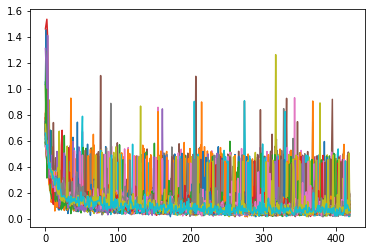

In [21]:
a_arr = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

for i in range(len(a_arr)):

  input_g_mtd_str = 'epochs_' + str(a_arr[i]) ## LINE

  print(input_g_mtd_str)

  run_prog('graph-BioNEV', 'LINE_Order2_weighted', input_g_mtd_str) ## .txt file

epochs_5
Iteration(train):  1
['epochs', 'bs', 'lr', 'hidden1', 'hidden2', 'hidden_decode1', 'dropout', 'emb_type', 'emb_category', 'input_type']
[15, 256, 0.001, 64, 32, 512, 0.5, 'graph-BioNEV', 'LINE_Order1_weighted', 'epochs_5']


--Sampled new data--
     Protein1_ID Protein2_ID  label
0         P63167      P03496      1
1         Q16576      P03428      1
2         P42336      P03496      1
3         Q04917      P03428      1
4         P49736      P03433      1
...          ...         ...    ...
7221      P21917      P03428      0
7222      Q5MJ70      P03485      0
7223      O95484      P06821      0
7224      Q8IXM3      P03437      0
7225      O15318      P03437      0

[7226 rows x 3 columns]
Loading PPI dataset...
15685
Embedding type: graph-BioNEV
Input method: epochs_5
 ==================== Feature Embeddings ==================== 
[[-0.04293258 -0.03450757  0.04300816 ... -0.00717379  0.04822948
   0.02855242]
 [-0.01245401 -0.0315447   0.00657524 ... -0.00106352  0.10626

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.6835723
epoch: 0001 loss_train: 0.1751 auroc_train: 0.9350 loss_val: 0.1540 auroc_val: 0.9891 auprc_val: 0.9891 f1_val: 0.9591 time: 9.8815s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.15543714
epoch: 0002 loss_train: 0.0643 auroc_train: 0.9942 loss_val: 0.2126 auroc_val: 0.9902 auprc_val: 0.9902 f1_val: 0.9319 time: 9.9049s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.058668908
epoch: 0003 loss_train: 0.0567 auroc_train: 0.9954 loss_val: 0.1169 auroc_val: 0.9875 auprc_val: 0.9885 f1_val: 0.9398 time: 9.8787s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.06760062
epoch: 0004 loss_train: 0.1097 auroc_train: 0.9942 loss_val: 0.1347 auroc_val: 0.9887 auprc_val: 0.9895 f1_val: 0.9431 time: 9.9381s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.03059571
epoch: 0005 loss_train: 0.1288 auroc_train: 0.9962 loss_val: 0.2462 auroc_val: 0.9875 auprc_val: 0.9888 f1_val: 0.9407 time: 9.92

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.69689935
epoch: 0001 loss_train: 0.1337 auroc_train: 0.9372 loss_val: 0.1651 auroc_val: 0.9869 auprc_val: 0.9856 f1_val: 0.9556 time: 10.0482s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.1514845
epoch: 0002 loss_train: 0.0868 auroc_train: 0.9943 loss_val: 0.1972 auroc_val: 0.9873 auprc_val: 0.9869 f1_val: 0.9108 time: 9.9793s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.10287388
epoch: 0003 loss_train: 0.0546 auroc_train: 0.9951 loss_val: 0.1758 auroc_val: 0.9887 auprc_val: 0.9881 f1_val: 0.9103 time: 9.9410s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.1562216
epoch: 0004 loss_train: 0.0442 auroc_train: 0.9964 loss_val: 0.1347 auroc_val: 0.9886 auprc_val: 0.9882 f1_val: 0.9172 time: 10.0686s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.058417015
epoch: 0005 loss_train: 0.0629 auroc_train: 0.9969 loss_val: 0.1637 auroc_val: 0.9876 auprc_val: 0.9874 f1_val: 0.9309 time: 10.

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.7571363
epoch: 0001 loss_train: 0.1669 auroc_train: 0.9274 loss_val: 0.1584 auroc_val: 0.9910 auprc_val: 0.9922 f1_val: 0.9361 time: 10.0433s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.14161047
epoch: 0002 loss_train: 0.0682 auroc_train: 0.9922 loss_val: 0.1364 auroc_val: 0.9883 auprc_val: 0.9900 f1_val: 0.9448 time: 10.0393s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.13490893
epoch: 0003 loss_train: 0.1122 auroc_train: 0.9947 loss_val: 0.1198 auroc_val: 0.9918 auprc_val: 0.9928 f1_val: 0.9565 time: 9.9827s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.030729512
epoch: 0004 loss_train: 0.1467 auroc_train: 0.9954 loss_val: 0.2213 auroc_val: 0.9912 auprc_val: 0.9921 f1_val: 0.9530 time: 10.0489s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.053485412
epoch: 0005 loss_train: 0.0532 auroc_train: 0.9952 loss_val: 0.1377 auroc_val: 0.9918 auprc_val: 0.9928 f1_val: 0.9520 time: 

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.68400574
epoch: 0001 loss_train: 0.2263 auroc_train: 0.9220 loss_val: 0.2068 auroc_val: 0.9858 auprc_val: 0.9858 f1_val: 0.9046 time: 10.0945s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.20285957
epoch: 0002 loss_train: 0.0766 auroc_train: 0.9924 loss_val: 0.1368 auroc_val: 0.9919 auprc_val: 0.9907 f1_val: 0.9578 time: 9.9108s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.067666866
epoch: 0003 loss_train: 0.0721 auroc_train: 0.9955 loss_val: 0.1612 auroc_val: 0.9884 auprc_val: 0.9874 f1_val: 0.9618 time: 10.0178s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.064255394
epoch: 0004 loss_train: 0.0841 auroc_train: 0.9967 loss_val: 0.0804 auroc_val: 0.9888 auprc_val: 0.9868 f1_val: 0.9526 time: 10.0298s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.05933793
epoch: 0005 loss_train: 0.0647 auroc_train: 0.9957 loss_val: 0.1788 auroc_val: 0.9906 auprc_val: 0.9880 f1_val: 0.9405 time:

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.6711072
epoch: 0001 loss_train: 0.1434 auroc_train: 0.9403 loss_val: 0.1218 auroc_val: 0.9948 auprc_val: 0.9945 f1_val: 0.9671 time: 10.8730s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.11740913
epoch: 0002 loss_train: 0.0606 auroc_train: 0.9953 loss_val: 0.1414 auroc_val: 0.9955 auprc_val: 0.9954 f1_val: 0.9445 time: 9.9972s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.0744612
epoch: 0003 loss_train: 0.0133 auroc_train: 0.9952 loss_val: 0.0754 auroc_val: 0.9958 auprc_val: 0.9958 f1_val: 0.9663 time: 10.1034s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.24810722
epoch: 0004 loss_train: 0.0593 auroc_train: 0.9943 loss_val: 0.0987 auroc_val: 0.9955 auprc_val: 0.9954 f1_val: 0.9468 time: 10.0451s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.06124743
epoch: 0005 loss_train: 0.0478 auroc_train: 0.9967 loss_val: 0.0902 auroc_val: 0.9961 auprc_val: 0.9960 f1_val: 0.9459 time: 10.

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.7106461
epoch: 0001 loss_train: 0.1013 auroc_train: 0.9794 loss_val: 0.4765 auroc_val: 0.9735 auprc_val: 0.9629 f1_val: 0.9125 time: 10.0184s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.15404053
epoch: 0002 loss_train: 0.0584 auroc_train: 0.9937 loss_val: 0.2301 auroc_val: 0.9817 auprc_val: 0.9783 f1_val: 0.8992 time: 10.0711s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.10050706
epoch: 0003 loss_train: 0.1416 auroc_train: 0.9949 loss_val: 0.3017 auroc_val: 0.9772 auprc_val: 0.9690 f1_val: 0.9220 time: 9.9477s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.047868963
epoch: 0004 loss_train: 0.4234 auroc_train: 0.9930 loss_val: 0.2647 auroc_val: 0.9786 auprc_val: 0.9729 f1_val: 0.9392 time: 10.1005s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.06070575
epoch: 0005 loss_train: 0.0486 auroc_train: 0.9939 loss_val: 0.2580 auroc_val: 0.9771 auprc_val: 0.9698 f1_val: 0.9011 time: 1

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.84348327
epoch: 0001 loss_train: 0.0936 auroc_train: 0.9656 loss_val: 0.1712 auroc_val: 0.9818 auprc_val: 0.9751 f1_val: 0.9255 time: 10.0433s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.08503582
epoch: 0002 loss_train: 0.0999 auroc_train: 0.9917 loss_val: 0.2336 auroc_val: 0.9882 auprc_val: 0.9859 f1_val: 0.9281 time: 9.9671s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.095999986
epoch: 0003 loss_train: 0.0648 auroc_train: 0.9942 loss_val: 0.2163 auroc_val: 0.9855 auprc_val: 0.9804 f1_val: 0.9272 time: 9.9805s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.056167744
epoch: 0004 loss_train: 0.0751 auroc_train: 0.9943 loss_val: 0.2209 auroc_val: 0.9861 auprc_val: 0.9829 f1_val: 0.9233 time: 9.9700s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.08647191
epoch: 0005 loss_train: 0.0623 auroc_train: 0.9941 loss_val: 0.1926 auroc_val: 0.9872 auprc_val: 0.9849 f1_val: 0.9106 time: 9

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.6484859
epoch: 0001 loss_train: 0.0750 auroc_train: 0.9771 loss_val: 0.2675 auroc_val: 0.9815 auprc_val: 0.9781 f1_val: 0.9395 time: 13.4336s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.10361631
epoch: 0002 loss_train: 0.0710 auroc_train: 0.9946 loss_val: 0.3231 auroc_val: 0.9815 auprc_val: 0.9799 f1_val: 0.9364 time: 10.0827s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.034319717
epoch: 0003 loss_train: 0.0287 auroc_train: 0.9953 loss_val: 0.3099 auroc_val: 0.9820 auprc_val: 0.9791 f1_val: 0.9405 time: 10.0431s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.08838569
epoch: 0004 loss_train: 0.0591 auroc_train: 0.9945 loss_val: 0.2095 auroc_val: 0.9826 auprc_val: 0.9802 f1_val: 0.9218 time: 9.9720s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.43861926
epoch: 0005 loss_train: 0.0920 auroc_train: 0.9947 loss_val: 0.1613 auroc_val: 0.9847 auprc_val: 0.9848 f1_val: 0.9358 time: 1

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.6799459
epoch: 0001 loss_train: 0.0498 auroc_train: 0.9729 loss_val: 0.2339 auroc_val: 0.9872 auprc_val: 0.9847 f1_val: 0.9149 time: 10.0278s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.12695658
epoch: 0002 loss_train: 0.0421 auroc_train: 0.9934 loss_val: 0.1470 auroc_val: 0.9893 auprc_val: 0.9892 f1_val: 0.9169 time: 10.0393s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.11706904
epoch: 0003 loss_train: 0.1107 auroc_train: 0.9936 loss_val: 0.1399 auroc_val: 0.9884 auprc_val: 0.9884 f1_val: 0.9469 time: 10.1484s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.08377413
epoch: 0004 loss_train: 0.0715 auroc_train: 0.9945 loss_val: 0.1912 auroc_val: 0.9884 auprc_val: 0.9885 f1_val: 0.9001 time: 10.0828s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.076321065
epoch: 0005 loss_train: 0.0607 auroc_train: 0.9926 loss_val: 0.1283 auroc_val: 0.9889 auprc_val: 0.9892 f1_val: 0.9461 time: 

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.65787876
epoch: 0001 loss_train: 0.0453 auroc_train: 0.9789 loss_val: 0.1871 auroc_val: 0.9840 auprc_val: 0.9795 f1_val: 0.9212 time: 10.0843s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.045235887
epoch: 0002 loss_train: 0.0673 auroc_train: 0.9929 loss_val: 0.2052 auroc_val: 0.9864 auprc_val: 0.9829 f1_val: 0.9349 time: 10.1109s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.114211805
epoch: 0003 loss_train: 0.1249 auroc_train: 0.9937 loss_val: 0.1300 auroc_val: 0.9880 auprc_val: 0.9860 f1_val: 0.9283 time: 10.1243s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.06315874
epoch: 0004 loss_train: 0.0643 auroc_train: 0.9938 loss_val: 0.1683 auroc_val: 0.9888 auprc_val: 0.9873 f1_val: 0.9436 time: 10.1256s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.1077541
epoch: 0005 loss_train: 0.0543 auroc_train: 0.9945 loss_val: 0.1471 auroc_val: 0.9877 auprc_val: 0.9859 f1_val: 0.9326 time:

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.807305
epoch: 0001 loss_train: 0.0917 auroc_train: 0.9415 loss_val: 0.5316 auroc_val: 0.9811 auprc_val: 0.9602 f1_val: 0.9333 time: 13.3366s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.1095867
epoch: 0002 loss_train: 0.2018 auroc_train: 0.9941 loss_val: 0.1597 auroc_val: 0.9805 auprc_val: 0.9599 f1_val: 0.9333 time: 10.1209s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.11432768
epoch: 0003 loss_train: 0.0705 auroc_train: 0.9959 loss_val: 0.9340 auroc_val: 0.9828 auprc_val: 0.9617 f1_val: 0.9381 time: 10.1853s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.07740392
epoch: 0004 loss_train: 0.0207 auroc_train: 0.9962 loss_val: 0.5694 auroc_val: 0.9807 auprc_val: 0.9596 f1_val: 0.9393 time: 10.2398s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.045840167
epoch: 0005 loss_train: 0.1371 auroc_train: 0.9962 loss_val: 0.1554 auroc_val: 0.9835 auprc_val: 0.9641 f1_val: 0.9195 time: 10

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.68555844
epoch: 0001 loss_train: 0.0962 auroc_train: 0.9556 loss_val: 0.1630 auroc_val: 0.9845 auprc_val: 0.9857 f1_val: 0.9233 time: 10.3933s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.09111553
epoch: 0002 loss_train: 0.1006 auroc_train: 0.9909 loss_val: 0.1545 auroc_val: 0.9889 auprc_val: 0.9894 f1_val: 0.9617 time: 10.3438s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.09900928
epoch: 0003 loss_train: 0.1250 auroc_train: 0.9931 loss_val: 0.2727 auroc_val: 0.9880 auprc_val: 0.9882 f1_val: 0.8987 time: 10.1899s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.048573148
epoch: 0004 loss_train: 0.0749 auroc_train: 0.9960 loss_val: 0.1528 auroc_val: 0.9879 auprc_val: 0.9885 f1_val: 0.8989 time: 10.2550s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.0505672
epoch: 0005 loss_train: 0.0416 auroc_train: 0.9962 loss_val: 0.1081 auroc_val: 0.9880 auprc_val: 0.9886 f1_val: 0.9273 time: 

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.655541
epoch: 0001 loss_train: 0.1056 auroc_train: 0.9579 loss_val: 0.1604 auroc_val: 0.9852 auprc_val: 0.9858 f1_val: 0.9395 time: 10.2569s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.13070726
epoch: 0002 loss_train: 0.0701 auroc_train: 0.9934 loss_val: 0.1997 auroc_val: 0.9863 auprc_val: 0.9867 f1_val: 0.9266 time: 10.1644s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.07774058
epoch: 0003 loss_train: 0.1244 auroc_train: 0.9951 loss_val: 0.1576 auroc_val: 0.9891 auprc_val: 0.9892 f1_val: 0.9342 time: 10.3080s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.115980275
epoch: 0004 loss_train: 0.0679 auroc_train: 0.9954 loss_val: 0.2342 auroc_val: 0.9888 auprc_val: 0.9891 f1_val: 0.9385 time: 10.2615s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.13724026
epoch: 0005 loss_train: 0.4949 auroc_train: 0.9947 loss_val: 0.2141 auroc_val: 0.9878 auprc_val: 0.9881 f1_val: 0.9395 time: 1

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.6639177
epoch: 0001 loss_train: 0.1160 auroc_train: 0.9618 loss_val: 0.1436 auroc_val: 0.9891 auprc_val: 0.9883 f1_val: 0.9512 time: 10.4010s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.09494712
epoch: 0002 loss_train: 0.1067 auroc_train: 0.9943 loss_val: 0.2826 auroc_val: 0.9905 auprc_val: 0.9895 f1_val: 0.9224 time: 10.3430s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.102464594
epoch: 0003 loss_train: 0.0956 auroc_train: 0.9959 loss_val: 0.1259 auroc_val: 0.9925 auprc_val: 0.9906 f1_val: 0.9524 time: 10.4183s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.12011389
epoch: 0004 loss_train: 0.1204 auroc_train: 0.9959 loss_val: 0.0857 auroc_val: 0.9868 auprc_val: 0.9876 f1_val: 0.9523 time: 10.5225s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.053058423
epoch: 0005 loss_train: 0.0631 auroc_train: 0.9960 loss_val: 0.4781 auroc_val: 0.9893 auprc_val: 0.9886 f1_val: 0.9265 time:

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.76265395
epoch: 0001 loss_train: 0.0866 auroc_train: 0.9579 loss_val: 0.5514 auroc_val: 0.9783 auprc_val: 0.9672 f1_val: 0.9337 time: 10.3426s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.19056796
epoch: 0002 loss_train: 0.0521 auroc_train: 0.9910 loss_val: 0.1754 auroc_val: 0.9840 auprc_val: 0.9840 f1_val: 0.9152 time: 10.3415s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.05600386
epoch: 0003 loss_train: 0.0950 auroc_train: 0.9937 loss_val: 0.3479 auroc_val: 0.9851 auprc_val: 0.9854 f1_val: 0.9317 time: 10.4100s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.11069131
epoch: 0004 loss_train: 0.0897 auroc_train: 0.9947 loss_val: 0.1958 auroc_val: 0.9845 auprc_val: 0.9845 f1_val: 0.9185 time: 10.4068s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.07025068
epoch: 0005 loss_train: 0.0549 auroc_train: 0.9953 loss_val: 0.1871 auroc_val: 0.9834 auprc_val: 0.9832 f1_val: 0.9289 time: 

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.7130821
epoch: 0001 loss_train: 0.1538 auroc_train: 0.9478 loss_val: 0.2225 auroc_val: 0.9817 auprc_val: 0.9813 f1_val: 0.9113 time: 10.4002s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.1375487
epoch: 0002 loss_train: 0.0929 auroc_train: 0.9868 loss_val: 0.1628 auroc_val: 0.9859 auprc_val: 0.9853 f1_val: 0.9128 time: 10.2990s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.16525772
epoch: 0003 loss_train: 0.0709 auroc_train: 0.9896 loss_val: 0.2178 auroc_val: 0.9866 auprc_val: 0.9862 f1_val: 0.9397 time: 10.3973s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.109797396
epoch: 0004 loss_train: 0.1251 auroc_train: 0.9925 loss_val: 0.1850 auroc_val: 0.9881 auprc_val: 0.9876 f1_val: 0.9326 time: 10.4580s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.079819456
epoch: 0005 loss_train: 0.1034 auroc_train: 0.9922 loss_val: 0.1612 auroc_val: 0.9874 auprc_val: 0.9871 f1_val: 0.9274 time: 

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.66217434
epoch: 0001 loss_train: 0.2233 auroc_train: 0.9569 loss_val: 0.2028 auroc_val: 0.9784 auprc_val: 0.9797 f1_val: 0.8979 time: 10.3052s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.15031111
epoch: 0002 loss_train: 0.1166 auroc_train: 0.9876 loss_val: 0.2122 auroc_val: 0.9793 auprc_val: 0.9809 f1_val: 0.9335 time: 10.2888s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.10425793
epoch: 0003 loss_train: 0.1022 auroc_train: 0.9891 loss_val: 0.2050 auroc_val: 0.9829 auprc_val: 0.9834 f1_val: 0.9249 time: 10.2413s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.14617321
epoch: 0004 loss_train: 0.1346 auroc_train: 0.9913 loss_val: 0.1997 auroc_val: 0.9839 auprc_val: 0.9844 f1_val: 0.9317 time: 10.3330s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.11644373
epoch: 0005 loss_train: 0.0776 auroc_train: 0.9897 loss_val: 0.2825 auroc_val: 0.9863 auprc_val: 0.9874 f1_val: 0.9083 time: 

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.6547488
epoch: 0001 loss_train: 0.1777 auroc_train: 0.9421 loss_val: 0.2303 auroc_val: 0.9680 auprc_val: 0.9672 f1_val: 0.9010 time: 10.3317s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.16212063
epoch: 0002 loss_train: 0.0885 auroc_train: 0.9890 loss_val: 0.2952 auroc_val: 0.9761 auprc_val: 0.9758 f1_val: 0.8303 time: 10.3892s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.2860728
epoch: 0003 loss_train: 0.1771 auroc_train: 0.9883 loss_val: 0.1899 auroc_val: 0.9748 auprc_val: 0.9750 f1_val: 0.9105 time: 13.7167s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.08605886
epoch: 0004 loss_train: 0.1087 auroc_train: 0.9919 loss_val: 0.2291 auroc_val: 0.9793 auprc_val: 0.9794 f1_val: 0.9195 time: 10.4764s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.08229866
epoch: 0005 loss_train: 0.0973 auroc_train: 0.9925 loss_val: 0.2414 auroc_val: 0.9805 auprc_val: 0.9802 f1_val: 0.9046 time: 10

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.71345323
epoch: 0001 loss_train: 0.1547 auroc_train: 0.9459 loss_val: 0.1985 auroc_val: 0.9723 auprc_val: 0.9724 f1_val: 0.8880 time: 10.3864s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.15916264
epoch: 0002 loss_train: 0.1696 auroc_train: 0.9860 loss_val: 0.2217 auroc_val: 0.9765 auprc_val: 0.9767 f1_val: 0.8682 time: 10.2615s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.09692334
epoch: 0003 loss_train: 0.1019 auroc_train: 0.9884 loss_val: 0.2031 auroc_val: 0.9801 auprc_val: 0.9807 f1_val: 0.9011 time: 10.3359s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.09109366
epoch: 0004 loss_train: 0.1050 auroc_train: 0.9901 loss_val: 0.5439 auroc_val: 0.9832 auprc_val: 0.9842 f1_val: 0.9292 time: 10.3700s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.10631748
epoch: 0005 loss_train: 0.1262 auroc_train: 0.9908 loss_val: 0.5599 auroc_val: 0.9852 auprc_val: 0.9863 f1_val: 0.9262 time: 

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.6554018
epoch: 0001 loss_train: 0.1902 auroc_train: 0.9467 loss_val: 0.2215 auroc_val: 0.9774 auprc_val: 0.9782 f1_val: 0.8960 time: 10.3242s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.1562718
epoch: 0002 loss_train: 0.1118 auroc_train: 0.9860 loss_val: 0.2395 auroc_val: 0.9829 auprc_val: 0.9833 f1_val: 0.9048 time: 10.2153s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.099763006
epoch: 0003 loss_train: 0.1422 auroc_train: 0.9905 loss_val: 0.1623 auroc_val: 0.9840 auprc_val: 0.9834 f1_val: 0.9223 time: 10.2356s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.08249135
epoch: 0004 loss_train: 0.0915 auroc_train: 0.9912 loss_val: 0.1897 auroc_val: 0.9841 auprc_val: 0.9735 f1_val: 0.9202 time: 10.1635s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.13127731
epoch: 0005 loss_train: 0.1183 auroc_train: 0.9920 loss_val: 0.1902 auroc_val: 0.9832 auprc_val: 0.9733 f1_val: 0.8967 time: 1

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.6329131
epoch: 0001 loss_train: 0.1943 auroc_train: 0.9305 loss_val: 0.1815 auroc_val: 0.9889 auprc_val: 0.9890 f1_val: 0.9214 time: 10.1336s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.17088963
epoch: 0002 loss_train: 0.1118 auroc_train: 0.9880 loss_val: 0.2044 auroc_val: 0.9860 auprc_val: 0.9867 f1_val: 0.9348 time: 10.1667s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.08657518
epoch: 0003 loss_train: 0.1092 auroc_train: 0.9907 loss_val: 0.2047 auroc_val: 0.9863 auprc_val: 0.9871 f1_val: 0.8996 time: 10.3059s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.09562062
epoch: 0004 loss_train: 0.0798 auroc_train: 0.9895 loss_val: 0.1470 auroc_val: 0.9896 auprc_val: 0.9900 f1_val: 0.9362 time: 10.2430s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.12019481
epoch: 0005 loss_train: 0.0729 auroc_train: 0.9940 loss_val: 0.1858 auroc_val: 0.9909 auprc_val: 0.9911 f1_val: 0.9341 time: 1

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.7247298
epoch: 0001 loss_train: 0.1285 auroc_train: 0.9420 loss_val: 0.1620 auroc_val: 0.9849 auprc_val: 0.9828 f1_val: 0.9243 time: 10.1236s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.1304018
epoch: 0002 loss_train: 0.1993 auroc_train: 0.9895 loss_val: 0.2452 auroc_val: 0.9833 auprc_val: 0.9811 f1_val: 0.9327 time: 10.2321s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.22236875
epoch: 0003 loss_train: 0.0687 auroc_train: 0.9907 loss_val: 0.1633 auroc_val: 0.9844 auprc_val: 0.9821 f1_val: 0.9385 time: 10.0965s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.0706917
epoch: 0004 loss_train: 0.1066 auroc_train: 0.9929 loss_val: 0.1896 auroc_val: 0.9855 auprc_val: 0.9827 f1_val: 0.9409 time: 10.1070s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.07446567
epoch: 0005 loss_train: 0.0708 auroc_train: 0.9943 loss_val: 0.2527 auroc_val: 0.9832 auprc_val: 0.9795 f1_val: 0.9086 time: 11.

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.68881917
epoch: 0001 loss_train: 0.1366 auroc_train: 0.9409 loss_val: 0.2126 auroc_val: 0.9745 auprc_val: 0.9760 f1_val: 0.9328 time: 10.0862s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.171647
epoch: 0002 loss_train: 0.1223 auroc_train: 0.9899 loss_val: 0.2086 auroc_val: 0.9786 auprc_val: 0.9787 f1_val: 0.9328 time: 10.2435s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.12933445
epoch: 0003 loss_train: 0.0834 auroc_train: 0.9917 loss_val: 0.2228 auroc_val: 0.9839 auprc_val: 0.9833 f1_val: 0.9350 time: 10.1135s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.08057445
epoch: 0004 loss_train: 0.0699 auroc_train: 0.9941 loss_val: 0.2159 auroc_val: 0.9838 auprc_val: 0.9836 f1_val: 0.9409 time: 10.1300s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.121914275
epoch: 0005 loss_train: 0.0800 auroc_train: 0.9944 loss_val: 0.2156 auroc_val: 0.9853 auprc_val: 0.9842 f1_val: 0.9017 time: 1

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.66036
epoch: 0001 loss_train: 0.1646 auroc_train: 0.9430 loss_val: 0.1723 auroc_val: 0.9813 auprc_val: 0.9822 f1_val: 0.9169 time: 10.1997s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.19551113
epoch: 0002 loss_train: 0.1224 auroc_train: 0.9881 loss_val: 0.2478 auroc_val: 0.9835 auprc_val: 0.9834 f1_val: 0.9205 time: 10.1699s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.10827428
epoch: 0003 loss_train: 0.0949 auroc_train: 0.9900 loss_val: 0.2543 auroc_val: 0.9827 auprc_val: 0.9705 f1_val: 0.8954 time: 10.1298s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.10838299
epoch: 0004 loss_train: 0.1011 auroc_train: 0.9902 loss_val: 0.2184 auroc_val: 0.9870 auprc_val: 0.9860 f1_val: 0.8605 time: 10.1723s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.11307138
epoch: 0005 loss_train: 0.0764 auroc_train: 0.9933 loss_val: 0.1645 auroc_val: 0.9867 auprc_val: 0.9858 f1_val: 0.9214 time: 10.

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.7096061
epoch: 0001 loss_train: 0.2241 auroc_train: 0.9221 loss_val: 0.2028 auroc_val: 0.9770 auprc_val: 0.9732 f1_val: 0.9038 time: 10.2972s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.19899443
epoch: 0002 loss_train: 0.1427 auroc_train: 0.9861 loss_val: 0.1306 auroc_val: 0.9856 auprc_val: 0.9857 f1_val: 0.9332 time: 10.1558s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.14113718
epoch: 0003 loss_train: 0.0795 auroc_train: 0.9891 loss_val: 0.2130 auroc_val: 0.9821 auprc_val: 0.9823 f1_val: 0.9076 time: 10.2195s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.0765195
epoch: 0004 loss_train: 0.0912 auroc_train: 0.9929 loss_val: 0.1621 auroc_val: 0.9870 auprc_val: 0.9865 f1_val: 0.9091 time: 10.1839s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.084459856
epoch: 0005 loss_train: 0.0541 auroc_train: 0.9938 loss_val: 0.2530 auroc_val: 0.9863 auprc_val: 0.9860 f1_val: 0.9229 time: 1

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.6266973
epoch: 0001 loss_train: 0.1658 auroc_train: 0.9534 loss_val: 0.2284 auroc_val: 0.9729 auprc_val: 0.9773 f1_val: 0.9216 time: 10.2770s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.17898983
epoch: 0002 loss_train: 0.1739 auroc_train: 0.9868 loss_val: 0.2605 auroc_val: 0.9788 auprc_val: 0.9812 f1_val: 0.9106 time: 10.1749s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.13639002
epoch: 0003 loss_train: 0.0939 auroc_train: 0.9887 loss_val: 0.1508 auroc_val: 0.9806 auprc_val: 0.9836 f1_val: 0.9106 time: 10.1976s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.09943927
epoch: 0004 loss_train: 0.1224 auroc_train: 0.9901 loss_val: 0.2811 auroc_val: 0.9796 auprc_val: 0.9835 f1_val: 0.9061 time: 10.2142s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.15527923
epoch: 0005 loss_train: 0.1164 auroc_train: 0.9919 loss_val: 0.1321 auroc_val: 0.9823 auprc_val: 0.9854 f1_val: 0.9132 time: 1

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.64960504
epoch: 0001 loss_train: 0.1903 auroc_train: 0.9508 loss_val: 0.2503 auroc_val: 0.9769 auprc_val: 0.9777 f1_val: 0.9138 time: 13.6413s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.1844372
epoch: 0002 loss_train: 0.1064 auroc_train: 0.9861 loss_val: 0.2162 auroc_val: 0.9824 auprc_val: 0.9822 f1_val: 0.9010 time: 10.3345s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.12810019
epoch: 0003 loss_train: 0.1027 auroc_train: 0.9880 loss_val: 0.1463 auroc_val: 0.9868 auprc_val: 0.9852 f1_val: 0.9569 time: 10.2286s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.116408564
epoch: 0004 loss_train: 0.1550 auroc_train: 0.9899 loss_val: 0.1280 auroc_val: 0.9846 auprc_val: 0.9825 f1_val: 0.9434 time: 10.1945s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.12642074
epoch: 0005 loss_train: 0.1077 auroc_train: 0.9922 loss_val: 0.2436 auroc_val: 0.9823 auprc_val: 0.9777 f1_val: 0.9364 time: 

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.69338185
epoch: 0001 loss_train: 0.1790 auroc_train: 0.9220 loss_val: 0.1752 auroc_val: 0.9831 auprc_val: 0.9842 f1_val: 0.9323 time: 10.4572s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.19411969
epoch: 0002 loss_train: 0.1015 auroc_train: 0.9854 loss_val: 0.1420 auroc_val: 0.9843 auprc_val: 0.9858 f1_val: 0.9108 time: 10.2008s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.13351442
epoch: 0003 loss_train: 0.1345 auroc_train: 0.9873 loss_val: 0.2260 auroc_val: 0.9830 auprc_val: 0.9847 f1_val: 0.9126 time: 10.2313s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.11485947
epoch: 0004 loss_train: 0.1135 auroc_train: 0.9895 loss_val: 0.2567 auroc_val: 0.9818 auprc_val: 0.9838 f1_val: 0.9304 time: 10.2055s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.089214645
epoch: 0005 loss_train: 0.1259 auroc_train: 0.9895 loss_val: 0.1763 auroc_val: 0.9839 auprc_val: 0.9855 f1_val: 0.9280 time:

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.751439
epoch: 0001 loss_train: 0.1122 auroc_train: 0.9460 loss_val: 0.2125 auroc_val: 0.9829 auprc_val: 0.9843 f1_val: 0.8829 time: 10.0354s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.13992153
epoch: 0002 loss_train: 0.1551 auroc_train: 0.9871 loss_val: 0.1697 auroc_val: 0.9876 auprc_val: 0.9877 f1_val: 0.9270 time: 10.1032s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.087995715
epoch: 0003 loss_train: 0.1334 auroc_train: 0.9899 loss_val: 0.1476 auroc_val: 0.9884 auprc_val: 0.9878 f1_val: 0.9188 time: 10.0606s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.08961105
epoch: 0004 loss_train: 0.1273 auroc_train: 0.9888 loss_val: 0.1178 auroc_val: 0.9894 auprc_val: 0.9887 f1_val: 0.9405 time: 10.0513s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.08996673
epoch: 0005 loss_train: 0.1271 auroc_train: 0.9925 loss_val: 0.1531 auroc_val: 0.9908 auprc_val: 0.9902 f1_val: 0.9324 time: 9

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.76135015
epoch: 0001 loss_train: 0.1698 auroc_train: 0.9155 loss_val: 0.1622 auroc_val: 0.9849 auprc_val: 0.9855 f1_val: 0.9499 time: 10.1502s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.20161937
epoch: 0002 loss_train: 0.1046 auroc_train: 0.9843 loss_val: 0.1593 auroc_val: 0.9861 auprc_val: 0.9864 f1_val: 0.9421 time: 10.1907s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.10335216
epoch: 0003 loss_train: 0.0990 auroc_train: 0.9883 loss_val: 0.1368 auroc_val: 0.9866 auprc_val: 0.9869 f1_val: 0.9178 time: 12.3270s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.12588713
epoch: 0004 loss_train: 0.1078 auroc_train: 0.9886 loss_val: 0.1533 auroc_val: 0.9900 auprc_val: 0.9900 f1_val: 0.9482 time: 11.3255s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.12308702
epoch: 0005 loss_train: 0.1116 auroc_train: 0.9916 loss_val: 0.1188 auroc_val: 0.9896 auprc_val: 0.9898 f1_val: 0.9496 time: 

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.7482949
epoch: 0001 loss_train: 0.0929 auroc_train: 0.9523 loss_val: 0.1500 auroc_val: 0.9906 auprc_val: 0.9901 f1_val: 0.9109 time: 10.1813s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.9215465
epoch: 0002 loss_train: 0.1016 auroc_train: 0.9912 loss_val: 0.1483 auroc_val: 0.9932 auprc_val: 0.9926 f1_val: 0.9432 time: 10.2830s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.088861935
epoch: 0003 loss_train: 0.1271 auroc_train: 0.9924 loss_val: 0.1693 auroc_val: 0.9937 auprc_val: 0.9931 f1_val: 0.8779 time: 10.2143s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.1363752
epoch: 0004 loss_train: 0.0666 auroc_train: 0.9928 loss_val: 0.2118 auroc_val: 0.9931 auprc_val: 0.9924 f1_val: 0.8946 time: 10.1881s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.087780036
epoch: 0005 loss_train: 0.1095 auroc_train: 0.9936 loss_val: 0.1562 auroc_val: 0.9935 auprc_val: 0.9926 f1_val: 0.9348 time: 1

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.7261011
epoch: 0001 loss_train: 0.5246 auroc_train: 0.9556 loss_val: 0.1981 auroc_val: 0.9857 auprc_val: 0.9874 f1_val: 0.9188 time: 10.1788s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.16844837
epoch: 0002 loss_train: 0.0619 auroc_train: 0.9926 loss_val: 0.1886 auroc_val: 0.9884 auprc_val: 0.9890 f1_val: 0.8914 time: 10.1028s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.12923491
epoch: 0003 loss_train: 0.1034 auroc_train: 0.9934 loss_val: 0.1465 auroc_val: 0.9883 auprc_val: 0.9891 f1_val: 0.9496 time: 10.2090s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.07112262
epoch: 0004 loss_train: 0.0557 auroc_train: 0.9940 loss_val: 0.1209 auroc_val: 0.9871 auprc_val: 0.9886 f1_val: 0.9412 time: 10.3177s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.14761263
epoch: 0005 loss_train: 0.1073 auroc_train: 0.9945 loss_val: 0.2785 auroc_val: 0.9878 auprc_val: 0.9897 f1_val: 0.8839 time: 1

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.71947587
epoch: 0001 loss_train: 0.1260 auroc_train: 0.9339 loss_val: 0.1532 auroc_val: 0.9909 auprc_val: 0.9906 f1_val: 0.9233 time: 10.1467s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.11900628
epoch: 0002 loss_train: 0.1008 auroc_train: 0.9911 loss_val: 0.1390 auroc_val: 0.9912 auprc_val: 0.9905 f1_val: 0.9472 time: 10.1664s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.064188585
epoch: 0003 loss_train: 0.2110 auroc_train: 0.9924 loss_val: 0.1298 auroc_val: 0.9888 auprc_val: 0.9879 f1_val: 0.9193 time: 10.1624s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.051266897
epoch: 0004 loss_train: 0.0546 auroc_train: 0.9934 loss_val: 0.1400 auroc_val: 0.9893 auprc_val: 0.9880 f1_val: 0.9348 time: 10.3205s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.06385591
epoch: 0005 loss_train: 0.4462 auroc_train: 0.9935 loss_val: 0.1574 auroc_val: 0.9895 auprc_val: 0.9882 f1_val: 0.9498 time

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.67874503
epoch: 0001 loss_train: 0.0999 auroc_train: 0.9519 loss_val: 0.1446 auroc_val: 0.9893 auprc_val: 0.9885 f1_val: 0.9374 time: 10.1016s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.14293572
epoch: 0002 loss_train: 0.1039 auroc_train: 0.9920 loss_val: 0.1590 auroc_val: 0.9867 auprc_val: 0.9835 f1_val: 0.9430 time: 10.1642s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.07305063
epoch: 0003 loss_train: 0.0469 auroc_train: 0.9937 loss_val: 0.1755 auroc_val: 0.9871 auprc_val: 0.9840 f1_val: 0.9351 time: 10.1198s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.43334752
epoch: 0004 loss_train: 0.0565 auroc_train: 0.9935 loss_val: 0.1649 auroc_val: 0.9870 auprc_val: 0.9836 f1_val: 0.9413 time: 10.3395s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.1052329
epoch: 0005 loss_train: 0.1162 auroc_train: 0.9921 loss_val: 0.1745 auroc_val: 0.9866 auprc_val: 0.9837 f1_val: 0.9533 time: 1

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.6639297
epoch: 0001 loss_train: 0.0981 auroc_train: 0.9557 loss_val: 0.2308 auroc_val: 0.9818 auprc_val: 0.9847 f1_val: 0.9420 time: 10.1455s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.12146551
epoch: 0002 loss_train: 0.1241 auroc_train: 0.9908 loss_val: 0.3426 auroc_val: 0.9843 auprc_val: 0.9877 f1_val: 0.9060 time: 10.1863s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.063476875
epoch: 0003 loss_train: 0.0721 auroc_train: 0.9928 loss_val: 0.1429 auroc_val: 0.9877 auprc_val: 0.9896 f1_val: 0.9366 time: 10.3088s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.085881375
epoch: 0004 loss_train: 0.0769 auroc_train: 0.9948 loss_val: 0.1177 auroc_val: 0.9892 auprc_val: 0.9909 f1_val: 0.9306 time: 10.1565s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.046736956
epoch: 0005 loss_train: 0.1209 auroc_train: 0.9928 loss_val: 0.2633 auroc_val: 0.9888 auprc_val: 0.9906 f1_val: 0.8797 time

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.77817833
epoch: 0001 loss_train: 0.1736 auroc_train: 0.9216 loss_val: 0.1863 auroc_val: 0.9805 auprc_val: 0.9834 f1_val: 0.9442 time: 10.0657s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.16932467
epoch: 0002 loss_train: 0.1502 auroc_train: 0.9911 loss_val: 0.1330 auroc_val: 0.9819 auprc_val: 0.9848 f1_val: 0.9196 time: 10.1067s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.089591146
epoch: 0003 loss_train: 0.0669 auroc_train: 0.9939 loss_val: 0.5810 auroc_val: 0.9811 auprc_val: 0.9837 f1_val: 0.9355 time: 10.2039s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.07776207
epoch: 0004 loss_train: 0.0636 auroc_train: 0.9955 loss_val: 0.5537 auroc_val: 0.9820 auprc_val: 0.9840 f1_val: 0.9263 time: 10.1211s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.082437344
epoch: 0005 loss_train: 0.0319 auroc_train: 0.9959 loss_val: 0.1676 auroc_val: 0.9823 auprc_val: 0.9844 f1_val: 0.9144 time

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.66557103
epoch: 0001 loss_train: 0.1487 auroc_train: 0.9417 loss_val: 0.1767 auroc_val: 0.9849 auprc_val: 0.9873 f1_val: 0.9547 time: 10.0380s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.11667725
epoch: 0002 loss_train: 0.0782 auroc_train: 0.9919 loss_val: 0.1494 auroc_val: 0.9853 auprc_val: 0.9880 f1_val: 0.9431 time: 10.1055s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.09917681
epoch: 0003 loss_train: 0.0818 auroc_train: 0.9949 loss_val: 0.0494 auroc_val: 0.9880 auprc_val: 0.9900 f1_val: 0.9574 time: 10.0097s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.08377329
epoch: 0004 loss_train: 0.0917 auroc_train: 0.9951 loss_val: 0.1351 auroc_val: 0.9872 auprc_val: 0.9896 f1_val: 0.9535 time: 10.0788s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.07720555
epoch: 0005 loss_train: 0.0590 auroc_train: 0.9961 loss_val: 0.1770 auroc_val: 0.9884 auprc_val: 0.9908 f1_val: 0.9472 time: 

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.69465446
epoch: 0001 loss_train: 0.1581 auroc_train: 0.9210 loss_val: 0.1463 auroc_val: 0.9809 auprc_val: 0.9788 f1_val: 0.9128 time: 10.0202s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.1582461
epoch: 0002 loss_train: 0.0868 auroc_train: 0.9913 loss_val: 0.1475 auroc_val: 0.9825 auprc_val: 0.9795 f1_val: 0.9076 time: 10.0722s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.06517036
epoch: 0003 loss_train: 0.0707 auroc_train: 0.9950 loss_val: 0.2553 auroc_val: 0.9826 auprc_val: 0.9792 f1_val: 0.9210 time: 10.0643s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.06370228
epoch: 0004 loss_train: 0.0754 auroc_train: 0.9958 loss_val: 0.1338 auroc_val: 0.9842 auprc_val: 0.9805 f1_val: 0.9172 time: 10.0482s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.065131985
epoch: 0005 loss_train: 0.0660 auroc_train: 0.9960 loss_val: 0.1922 auroc_val: 0.9850 auprc_val: 0.9811 f1_val: 0.9328 time: 

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.6738009
epoch: 0001 loss_train: 0.1827 auroc_train: 0.9357 loss_val: 0.1945 auroc_val: 0.9864 auprc_val: 0.9869 f1_val: 0.9501 time: 10.1332s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.15384518
epoch: 0002 loss_train: 0.0687 auroc_train: 0.9901 loss_val: 0.2116 auroc_val: 0.9895 auprc_val: 0.9896 f1_val: 0.8898 time: 10.1606s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.13992663
epoch: 0003 loss_train: 0.0629 auroc_train: 0.9919 loss_val: 0.2041 auroc_val: 0.9896 auprc_val: 0.9898 f1_val: 0.9099 time: 10.0293s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.086681634
epoch: 0004 loss_train: 0.8740 auroc_train: 0.9941 loss_val: 0.2522 auroc_val: 0.9856 auprc_val: 0.9861 f1_val: 0.8824 time: 10.2150s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.06348956
epoch: 0005 loss_train: 0.0565 auroc_train: 0.9943 loss_val: 0.2075 auroc_val: 0.9884 auprc_val: 0.9891 f1_val: 0.9056 time: 

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.7028405
epoch: 0001 loss_train: 0.2279 auroc_train: 0.8983 loss_val: 0.3049 auroc_val: 0.9630 auprc_val: 0.9587 f1_val: 0.8358 time: 11.2646s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.2444071
epoch: 0002 loss_train: 0.0845 auroc_train: 0.9899 loss_val: 0.1559 auroc_val: 0.9831 auprc_val: 0.9809 f1_val: 0.9020 time: 12.0634s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.11797138
epoch: 0003 loss_train: 0.0593 auroc_train: 0.9947 loss_val: 0.2781 auroc_val: 0.9811 auprc_val: 0.9801 f1_val: 0.9314 time: 10.0645s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.11568539
epoch: 0004 loss_train: 0.0594 auroc_train: 0.9951 loss_val: 0.2011 auroc_val: 0.9830 auprc_val: 0.9810 f1_val: 0.9412 time: 10.0491s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.074474946
epoch: 0005 loss_train: 0.0696 auroc_train: 0.9955 loss_val: 0.1833 auroc_val: 0.9869 auprc_val: 0.9856 f1_val: 0.8969 time: 1

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.74813515
epoch: 0001 loss_train: 0.1187 auroc_train: 0.9541 loss_val: 0.1775 auroc_val: 0.9883 auprc_val: 0.9881 f1_val: 0.9312 time: 10.3136s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.09487799
epoch: 0002 loss_train: 0.1359 auroc_train: 0.9932 loss_val: 0.1384 auroc_val: 0.9860 auprc_val: 0.9868 f1_val: 0.9388 time: 10.1345s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.10745139
epoch: 0003 loss_train: 0.0574 auroc_train: 0.9947 loss_val: 0.1311 auroc_val: 0.9870 auprc_val: 0.9879 f1_val: 0.9270 time: 10.1912s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.050631654
epoch: 0004 loss_train: 0.0988 auroc_train: 0.9955 loss_val: 0.2371 auroc_val: 0.9867 auprc_val: 0.9872 f1_val: 0.9194 time: 10.1098s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.07212018
epoch: 0005 loss_train: 0.0949 auroc_train: 0.9958 loss_val: 0.1991 auroc_val: 0.9870 auprc_val: 0.9879 f1_val: 0.9289 time:

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.6822742
epoch: 0001 loss_train: 0.1693 auroc_train: 0.9428 loss_val: 0.1586 auroc_val: 0.9834 auprc_val: 0.9806 f1_val: 0.9185 time: 10.4276s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.09604314
epoch: 0002 loss_train: 0.1063 auroc_train: 0.9937 loss_val: 0.1010 auroc_val: 0.9884 auprc_val: 0.9856 f1_val: 0.9344 time: 10.2643s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.44657347
epoch: 0003 loss_train: 0.0749 auroc_train: 0.9942 loss_val: 0.1670 auroc_val: 0.9890 auprc_val: 0.9854 f1_val: 0.9335 time: 10.2761s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.0655178
epoch: 0004 loss_train: 0.1318 auroc_train: 0.9955 loss_val: 0.1490 auroc_val: 0.9896 auprc_val: 0.9865 f1_val: 0.9106 time: 10.2377s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.105960265
epoch: 0005 loss_train: 0.4320 auroc_train: 0.9955 loss_val: 0.1395 auroc_val: 0.9886 auprc_val: 0.9864 f1_val: 0.9292 time: 1

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.6913828
epoch: 0001 loss_train: 0.0960 auroc_train: 0.9502 loss_val: 0.1123 auroc_val: 0.9949 auprc_val: 0.9947 f1_val: 0.9485 time: 10.1689s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.10586868
epoch: 0002 loss_train: 0.0453 auroc_train: 0.9925 loss_val: 0.2595 auroc_val: 0.9929 auprc_val: 0.9931 f1_val: 0.8555 time: 10.2031s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.14926577
epoch: 0003 loss_train: 0.1632 auroc_train: 0.9932 loss_val: 0.0982 auroc_val: 0.9946 auprc_val: 0.9948 f1_val: 0.9447 time: 10.0878s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.072719164
epoch: 0004 loss_train: 0.1587 auroc_train: 0.9931 loss_val: 0.1062 auroc_val: 0.9937 auprc_val: 0.9937 f1_val: 0.9455 time: 10.1796s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.0894192
epoch: 0005 loss_train: 0.1339 auroc_train: 0.9943 loss_val: 0.1421 auroc_val: 0.9952 auprc_val: 0.9952 f1_val: 0.9355 time: 1

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.7014202
epoch: 0001 loss_train: 0.1394 auroc_train: 0.9495 loss_val: 0.1176 auroc_val: 0.9873 auprc_val: 0.9887 f1_val: 0.9306 time: 10.1421s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.08026083
epoch: 0002 loss_train: 0.0674 auroc_train: 0.9924 loss_val: 0.1765 auroc_val: 0.9887 auprc_val: 0.9890 f1_val: 0.9355 time: 10.1539s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.05375566
epoch: 0003 loss_train: 0.0743 auroc_train: 0.9934 loss_val: 0.1372 auroc_val: 0.9917 auprc_val: 0.9927 f1_val: 0.9550 time: 10.3033s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.16747895
epoch: 0004 loss_train: 0.1075 auroc_train: 0.9947 loss_val: 0.2089 auroc_val: 0.9898 auprc_val: 0.9914 f1_val: 0.9199 time: 10.1431s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.084563464
epoch: 0005 loss_train: 0.0783 auroc_train: 0.9941 loss_val: 0.2115 auroc_val: 0.9896 auprc_val: 0.9908 f1_val: 0.9322 time: 

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.68132246
epoch: 0001 loss_train: 0.1053 auroc_train: 0.9560 loss_val: 0.1941 auroc_val: 0.9840 auprc_val: 0.9843 f1_val: 0.9324 time: 10.2351s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.13414732
epoch: 0002 loss_train: 0.0991 auroc_train: 0.9932 loss_val: 0.2159 auroc_val: 0.9884 auprc_val: 0.9881 f1_val: 0.9045 time: 10.1291s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.12482118
epoch: 0003 loss_train: 0.0875 auroc_train: 0.9945 loss_val: 0.1202 auroc_val: 0.9914 auprc_val: 0.9908 f1_val: 0.9383 time: 13.4861s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.09526595
epoch: 0004 loss_train: 0.0740 auroc_train: 0.9952 loss_val: 0.1971 auroc_val: 0.9918 auprc_val: 0.9908 f1_val: 0.9226 time: 10.2666s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.0990947
epoch: 0005 loss_train: 0.0644 auroc_train: 0.9956 loss_val: 0.1755 auroc_val: 0.9925 auprc_val: 0.9920 f1_val: 0.9197 time: 1

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.7149507
epoch: 0001 loss_train: 0.1977 auroc_train: 0.9439 loss_val: 0.1988 auroc_val: 0.9795 auprc_val: 0.9790 f1_val: 0.9086 time: 10.1570s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.23603335
epoch: 0002 loss_train: 0.1658 auroc_train: 0.9827 loss_val: 0.2182 auroc_val: 0.9824 auprc_val: 0.9822 f1_val: 0.9004 time: 10.2866s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.08646931
epoch: 0003 loss_train: 0.1437 auroc_train: 0.9872 loss_val: 0.1608 auroc_val: 0.9864 auprc_val: 0.9866 f1_val: 0.9076 time: 10.2471s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.12764025
epoch: 0004 loss_train: 0.1447 auroc_train: 0.9909 loss_val: 0.1579 auroc_val: 0.9799 auprc_val: 0.9812 f1_val: 0.9344 time: 10.1601s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.3051823
epoch: 0005 loss_train: 0.0999 auroc_train: 0.9930 loss_val: 0.1897 auroc_val: 0.9872 auprc_val: 0.9873 f1_val: 0.9468 time: 10

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.7775847
epoch: 0001 loss_train: 0.1900 auroc_train: 0.9319 loss_val: 0.1564 auroc_val: 0.9835 auprc_val: 0.9822 f1_val: 0.9189 time: 10.1615s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.14629458
epoch: 0002 loss_train: 0.0887 auroc_train: 0.9844 loss_val: 0.1857 auroc_val: 0.9860 auprc_val: 0.9855 f1_val: 0.9068 time: 10.1481s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.1648651
epoch: 0003 loss_train: 0.3617 auroc_train: 0.9890 loss_val: 0.2261 auroc_val: 0.9854 auprc_val: 0.9854 f1_val: 0.9332 time: 10.2017s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.095211364
epoch: 0004 loss_train: 0.1131 auroc_train: 0.9915 loss_val: 0.1178 auroc_val: 0.9862 auprc_val: 0.9865 f1_val: 0.9416 time: 10.2315s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.09614579
epoch: 0005 loss_train: 0.0924 auroc_train: 0.9932 loss_val: 0.1045 auroc_val: 0.9896 auprc_val: 0.9894 f1_val: 0.9460 time: 1

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.6958885
epoch: 0001 loss_train: 0.1444 auroc_train: 0.9394 loss_val: 0.1981 auroc_val: 0.9870 auprc_val: 0.9865 f1_val: 0.9389 time: 10.1726s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.24951562
epoch: 0002 loss_train: 0.1390 auroc_train: 0.9870 loss_val: 0.1098 auroc_val: 0.9893 auprc_val: 0.9889 f1_val: 0.9407 time: 10.1367s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.1087368
epoch: 0003 loss_train: 0.1513 auroc_train: 0.9896 loss_val: 0.1694 auroc_val: 0.9906 auprc_val: 0.9900 f1_val: 0.9497 time: 10.1537s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.09504415
epoch: 0004 loss_train: 0.0733 auroc_train: 0.9938 loss_val: 0.2237 auroc_val: 0.9890 auprc_val: 0.9887 f1_val: 0.9383 time: 10.2777s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.066923976
epoch: 0005 loss_train: 0.0544 auroc_train: 0.9941 loss_val: 0.1674 auroc_val: 0.9891 auprc_val: 0.9891 f1_val: 0.9474 time: 1

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.7092367
epoch: 0001 loss_train: 0.1430 auroc_train: 0.9405 loss_val: 0.2157 auroc_val: 0.9756 auprc_val: 0.9755 f1_val: 0.9235 time: 10.1219s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.17702562
epoch: 0002 loss_train: 0.1508 auroc_train: 0.9866 loss_val: 0.2332 auroc_val: 0.9806 auprc_val: 0.9813 f1_val: 0.9054 time: 10.1020s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.09812066
epoch: 0003 loss_train: 0.0673 auroc_train: 0.9914 loss_val: 0.1794 auroc_val: 0.9846 auprc_val: 0.9847 f1_val: 0.9372 time: 10.1798s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.09901534
epoch: 0004 loss_train: 0.1854 auroc_train: 0.9910 loss_val: 0.2089 auroc_val: 0.9813 auprc_val: 0.9808 f1_val: 0.9398 time: 10.1306s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.19349727
epoch: 0005 loss_train: 0.0738 auroc_train: 0.9923 loss_val: 0.2693 auroc_val: 0.9798 auprc_val: 0.9779 f1_val: 0.9194 time: 1

<ipython-input-7-7bae941e7522>:12: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


epoch: 1/ iteration: 1/ loss_train: 0.6910561
epoch: 0001 loss_train: 0.1991 auroc_train: 0.9385 loss_val: 0.2088 auroc_val: 0.9776 auprc_val: 0.9770 f1_val: 0.9212 time: 10.4633s
-------- Epoch 2 --------
epoch: 2/ iteration: 1/ loss_train: 0.16240443
epoch: 0002 loss_train: 0.1289 auroc_train: 0.9869 loss_val: 0.2448 auroc_val: 0.9757 auprc_val: 0.9754 f1_val: 0.9273 time: 10.5024s
-------- Epoch 3 --------
epoch: 3/ iteration: 1/ loss_train: 0.10071627
epoch: 0003 loss_train: 0.1215 auroc_train: 0.9906 loss_val: 0.2067 auroc_val: 0.9809 auprc_val: 0.9811 f1_val: 0.9272 time: 10.3651s
-------- Epoch 4 --------
epoch: 4/ iteration: 1/ loss_train: 0.4918355
epoch: 0004 loss_train: 0.0588 auroc_train: 0.9931 loss_val: 0.1648 auroc_val: 0.9844 auprc_val: 0.9837 f1_val: 0.9352 time: 13.6895s
-------- Epoch 5 --------
epoch: 5/ iteration: 1/ loss_train: 0.10405927
epoch: 0005 loss_train: 0.0542 auroc_train: 0.9938 loss_val: 0.1618 auroc_val: 0.9861 auprc_val: 0.9855 f1_val: 0.9461 time: 10

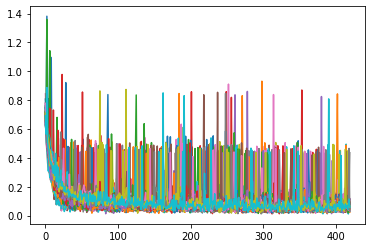

In [22]:
a_arr = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

for i in range(len(a_arr)):

  input_g_mtd_str = 'epochs_' + str(a_arr[i]) ## LINE

  print(input_g_mtd_str)

  run_prog('graph-BioNEV', 'LINE_Order1_weighted', input_g_mtd_str) ## .txt file

In [23]:
# '''
#   node2vec (num_walks = 8, walk_length = 64)
# '''
# a_arr = [0.25, 0.5, 1, 2, 4]
# b_arr = [0.25, 0.5, 1, 2, 4]

# for i in range (len(a_arr)):
    
#     for j in range(len(b_arr)):
        
#         input_g_mtd_str = 'p' + str(a_arr[i]) + '_q' + str(b_arr[j]) ## node2vec+

#         print(input_g_mtd_str)
        
#         run_prog('graph', 'node2vec_nw8_wl64', input_g_mtd_str) ## .txt file

In [24]:
# '''
#   LINE (Order 3)
# '''
# a_arr = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

# for i in range(len(a_arr)):

#   input_g_mtd_str = 'epochs_' + str(a_arr[i]) ## LINE

#   print(input_g_mtd_str)

#   run_prog('graph-BioNEV', 'LINE_Order3_weighted', input_g_mtd_str) ## .txt file

In [25]:
# '''
#   node2vec+ (num_walks = 8, walk_length = 64)
# '''
# a_arr = [0.25, 0.5, 1, 2, 4]
# b_arr = [0.25, 0.5, 1, 2, 4]

# for i in range (len(a_arr)):
    
#     for j in range(len(b_arr)):
        
#         input_g_mtd_str = 'n2v_plus_p' + str(a_arr[i]) + '_q' + str(b_arr[j]) ## node2vec+

#         print(input_g_mtd_str)
        
#         run_prog('graph-BioNEV', 'node2vec_plus_nw8_wl64', input_g_mtd_str) ## .txt file

In [26]:
# ## LINE 
# # a_arr = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

# ## GraRep
# # a_arr = [1, 2, 4, 8]

# ## VAE
# a_arr = [16, 32, 64, 128, 256, 512] ##hidden1
# b_arr = [8, 16, 32, 64, 128, 256] ##hidden2

# for i in range(len(a_arr)):

#   # input_g_mtd_str = 'bs1024_epochs' + str(a_arr[i]) ## LINE
#   # input_g_mtd_str = 'k' + str(a_arr[i]) ## GraRep
#   input_g_mtd_str = 'h' + str(a_arr[i]) + '_' + str(b_arr[i]) ## VAE

#   print(input_g_mtd_str)

#   # run_prog('graph', input_g_mtd_str) ## LINE
#   run_prog('graph-BioNEV', input_g_mtd_str) ## GraRep, VAE

In [27]:
# #### Graph embedding #####

# ## SDNE
# a_arr = [0, 0.1, 0.2, 0.3, 0.4]
# a_arr = [0, 10, 20, 30]

# ## struc2vec
# a_arr = [8, 16, 32, 64, 128] ## num_walks
# b_arr = [8, 16, 32, 64, 128] ## walk_length

# ## node2vec
# a_arr = [0.25, 0.5, 1, 2, 4]
# b_arr = [0.25, 0.5, 1, 2, 4]

# ## ripple2vec
# a_arr = [8, 16, 32, 64, 128]
# b_arr = [8, 16, 32, 64, 128]

In [28]:
# for i in range (len(a_arr)):
    
#     for j in range(len(b_arr)):
        
#         a_str = str(a_arr[i])
#         b_str = str(b_arr[j])
        
#         # input_g_mtd_str = 'a' + a_str + '_b' + b_str ## SDNE
#         input_g_mtd_str = 'nw' + a_str + '_wl' + b_str ## struc2vec, ripple2vec
#         # input_g_mtd_str = 'p' + a_str + '_q' + b_str ## node2vec

#         print(input_g_mtd_str)
        
#         run_prog('graph-BioNEV', input_g_mtd_str) ## .txt file
#         # run_prog('graph', input_g_mtd_str) ## .csv file

In [29]:
# ### num_walks/walk_length=256
# str_arr = [8, 16, 32]

# for i in range (len(str_arr)):
#     get_str = str(str_arr[i])
        
#     input_g_mtd_str = 'nw' + str(256) + '_wl' + str(str_arr[i])

#     print(input_g_mtd_str)

#     run_prog('graph', input_g_mtd_str) 

# for i in range (len(str_arr)):
#     get_str = str(str_arr[i])
        
#     input_g_mtd_str = 'nw' + str(str_arr[i]) + '_wl' + str(256)

#     print(input_g_mtd_str)

#     run_prog('graph', input_g_mtd_str) 

In [30]:
# ##### Protein embedding #####

# p_emb_arr = ['AAC', 'DPC', 'CTD', 'QSOrder', 'APAAC', 'CT', 'NMBroto']

# for i in range(len(p_emb_arr)):
  
#   input_g_mtd_str = p_emb_arr[i]

#   run_prog('protein', input_g_mtd_str)

In [31]:
# input_g_mtd_arr = ['dw-n2v-grarep-sdne', 'dw-n2v-grarep-line-sdne', 's2v-grarep-line-sdne', 'dw-n2v-s2v-grarep-sdne'] ## graph_combi
# input_g_mtd_arr = ['dw_nw8_wl32', 'n2v_p2_q0.5', 's2v_nw32_wl64', 'LINE_epochs25'] ## graph
# input_g_mtd_arr = ['SDNE_a0_b10', 'GraRep_k2'] ## graph-sdne-grarep
# input_g_mtd_arr = ['SDNE_default'] 

In [32]:
# for i in range(len(input_g_mtd_arr)):
  
#   # print(input_emb_type_arr[i]) # input_emb_type_arr = ['graph-sdne-grarep', 'graph', 'graph']
  
#   print(input_g_mtd_arr[i])

#   run_prog('graph-sdne-grarep', input_g_mtd_arr[i]) ## graph, graph-sdne-grarep, graph_combi

#   print("************************************************** DONE " + str(i+1) + " **************************************************")


In [33]:
# eval_metrics = []

# ## 5-fold Cross Validation
# for i in range(0, 5):

#     print('Iteration(train): ', (i+1))
#     # acc = train(emb_type='hvppi', input_type='hvppi') ## Samples new data, overwrite hyperparams here
#     acc = train(emb_type='graph_combi', input_type='s2v-sdne') 
    
#     eval_metrics.append(acc)
#     print(eval_metrics)

# # save_mtd = 'node2vec_50p'
# # np.save(get_path + 'data/eval_matrices/' + save_mtd + '.npy', eval_metrics)

In [34]:
## 1 Iteration
# acc = train() ## Samples new data
# eval_metrics.append(acc)
# print(eval_metrics)

## Evaluation

In [35]:
## Append results here
# eval_arr = eval_metrics

In [36]:
# mean = np.array(eval_arr).mean(axis=0) # Take the mean of each column
# mean = np.round(mean, 4)
# print('Mean: ' + str(mean)[1:-1])

# max = np.array(eval_arr).max(axis=0)
# max = np.round(max, 4)
# print('Max: ' + str(max)[1:-1])

# min = np.array(eval_arr).min(axis=0)
# min = np.round(min, 4)
# print('Min: ' + str(min)[1:-1])

In [37]:
## CHANGE METHOD HERE
# mtd_name = 'combi_1'

In [38]:
# with open(get_path + 'GraphEmbCombi_results.txt', "a") as f:
#     f.write(mtd_name + ': ' + str(mean) + '\n')

In [39]:
############### DATASETS INPUT HERE ###############
# def create_fold():

#     # return train, val, test

#     # ### 0.99 threshold
#     # pos_org = pd.read_csv(data_path + 'edges/positive_edges_0.99.csv')
    
#     # # neg_org = pd.read_csv(data_path + 'edges/negative_edges_all.csv')
#     # neg_org = pd.read_csv(data_path + 'edges/negative_edges_12.5p.csv')
#     # neg_org = pd.read_csv(data_path + 'edges/negative_edges_25p.csv')

#     ## Struct2Graph
#     pos_org = pd.read_csv(data_path + 'edges/positive_edges_struct2graph.csv')
#     neg_org = pd.read_csv(data_path + 'edges/negative_edges_struct2graph.csv')
    
#     '''
#         Shuffle Data
#     '''
#     pos = shuffle(pos_org)
#     neg = shuffle(neg_org)

#     # Sample positive dataset (for _struct2graph)
#     pos = pos[:len(neg)]

#     ## Sample negative dataset
#     # neg = neg[:len(pos)]

#     # print(pos)
#     # print(len(pos))

#     ## Train : Val : Test = 67.5 : 12.5 : 20
#     # pos_test = pos.sample(frac = 0.2, replace = False) ## 20% of positive dataset
#     # pos_train_val = pos[~pos.index.isin(pos_test.index)]
#     # pos_val = pos_train_val.sample(frac = 0.125, replace = False) ## 12.5% of remaining 80% 
#     # pos_train = pos_train_val[~pos_train_val.index.isin(pos_val.index)]

#     # neg_test = neg.sample(frac = 0.2, replace = False) ## 20% of negative dataset
#     # neg_train_val = neg[~neg.index.isin(neg_test.index)]
#     # neg_val = neg_train_val.sample(frac = 0.125, replace = False) ## 12.5% of remaining 80% 
#     # neg_train = neg_train_val[~neg_train_val.index.isin(neg_val.index)]

#     ## Train : Val : Test = 8 : 1 : 1
#     pos_test = pos.sample(frac = 0.1, replace = False) ## 10% of positive dataset
#     pos_train_val = pos[~pos.index.isin(pos_test.index)]
#     pos_val = pos_train_val.sample(frac = 0.1, replace = False) ## 10% of remaining 80% 
#     pos_train = pos_train_val[~pos_train_val.index.isin(pos_val.index)]

#     neg_test = neg.sample(frac = 0.1, replace = False) 
#     neg_train_val = neg[~neg.index.isin(neg_test.index)]
#     neg_val = neg_train_val.sample(frac = 0.1, replace = False) 
#     neg_train = neg_train_val[~neg_train_val.index.isin(neg_val.index)]
    
#     train_df = pd.concat([pos_train, neg_train], ignore_index=True)
#     val_df = pd.concat([pos_val, neg_val], ignore_index=True)
#     test_df = pd.concat([pos_test, neg_test], ignore_index=True)


#     # print(len(train_df), len(val_df), len(test_df)) ## 4022, 574, 1148

#     ## Using random sampling of remaining pos and neg dataset as the test set
#     # test_size = 1148
#     # test_set = pd.read_csv()
#     # test_df = shuffle(test_set)
#     # test_df = test_df[:test_size] 

#     ## Held-out test set - used exclusively in the test dataset (Held-out)

#     print('--Sampled new data--')

#     return train_df, val_df, test_df